<a href="https://colab.research.google.com/github/YasserElmenshawy/detect-covid-from-gough/blob/main/first_model_with_augmantation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os

In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 798, done.
remote: Total 798 (delta 0), reused 0 (delta 0), pack-reused 798
Receiving objects: 100% (798/798), 15.97 GiB | 13.76 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Checking out files: 100% (202/202), done.


In [ ]:
rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

20220224
20210206
20200413
20200824
20200416
20200930
20200504
20210618
20200525
20210406
20210914
20200505
20200814
20210630
20200707
20200919
20200901
20200424
20210714
20201031
20210816
20210930
20210419
20200820
20210426
20201012
20200803
20220116
20200604
20210507
20210523
20200720
20210603
20200430
20200418
20200415
20200417
20201221
20200419
20200911
20200502
20201130
20210830


In [ ]:
!wget https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'

--2022-03-04 17:00:52--  https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951442487 (907M) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>] 907.37M  2.44MB/s    in 4m 30s  

2022-03-04 17:05:24 (3.36 MB/s) - ‘public_dataset.zip?download=1’ saved [951442487/951442487]



In [ ]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData1=pd.concat(df_list)
CosData1['DataSet'] = 'coswara'
CosData1.head()

100%|██████████| 2745/2745 [00:27<00:00, 99.25it/s]


,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,GlIfVHLGwZejdqrR3MmBcxUBTWi1,under_validation,/content/Coswara-Data/20220224/GlIfVHLGwZejdqr...,0,0,coswara
0,cP1Dvsaa6cfAv6mlTjsH8Ezf2i63,positive_mild,/content/Coswara-Data/20220224/cP1Dvsaa6cfAv6m...,1,1,coswara
0,5uJzEx2zAfV2XQ8147WgYYWVeOF3,resp_illness_not_identified,/content/Coswara-Data/20220224/5uJzEx2zAfV2XQ8...,0,1,coswara
0,MwKKn2w3qpcQr260pQXCLbR26WT2,positive_asymp,/content/Coswara-Data/20220224/MwKKn2w3qpcQr26...,0,0,coswara
0,rMIXci2Er1OpK4ObuqY15yH4qsv1,under_validation,/content/Coswara-Data/20220224/rMIXci2Er1OpK4O...,0,0,coswara


In [ ]:
CosData1['STATUS'].unique()

array(['under_validation', 'positive_mild', 'resp_illness_not_identified',
       'positive_asymp', 'recovered_full', 'healthy', 'positive_moderate',
       'no_resp_illness_exposed'], dtype=object)

In [ ]:
positive_mild = CosData1.loc[CosData1['STATUS']=='positive_mild']
positive_moderate	 = CosData1.loc[CosData1['STATUS']=='positive_moderate']
positive_asymp = CosData1.loc[CosData1['STATUS']=='positive_asymp']

positive = pd.concat([positive_mild,positive_moderate,positive_asymp])

healthy = CosData1.loc[CosData1['STATUS']=='healthy']
resp_illness_not_identified = CosData1.loc[CosData1['STATUS']=='resp_illness_not_identified']
no_resp_illness_exposed = CosData1.loc[CosData1['STATUS']=='no_resp_illness_exposed']
recovered_full = CosData1.loc[CosData1['STATUS']=='recovered_full']

negative =  pd.concat([healthy,resp_illness_not_identified,no_resp_illness_exposed,recovered_full])

print(len(positive))
print(len(negative))

f_negative = negative.loc[negative['STATUS']!='COVID-19'][0:1500]
print(len(f_negative))




681
1983
1500


In [ ]:
coughvid  = '/content/public_dataset/'
custpath  = '/content/custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19']

TotData   = pd.concat([extradata,notradata],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
## TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
0,619d3192-2b16-4be4-ba00-fa58d61f7850,0,0,healthy,/content/public_dataset/619d3192-2b16-4be4-ba0...,coughvid
1,68d25e35-8946-474c-88ff-7a452ecc57b8,0,0,healthy,/content/public_dataset/68d25e35-8946-474c-88f...,coughvid
2,8094f4ee-3417-4882-af51-9996bebb2140,1,0,symptomatic,/content/public_dataset/8094f4ee-3417-4882-af5...,coughvid
3,26e4d0d9-a03c-4564-b15e-d8850bb4a2a3,1,0,healthy,/content/public_dataset/26e4d0d9-a03c-4564-b15...,coughvid
4,43298143-1004-44ef-889f-10ba9dc9d51f,0,1,symptomatic,/content/public_dataset/43298143-1004-44ef-889...,coughvid


In [ ]:
covid_TotData = TotData[TotData["STATUS"] == "COVID-19" ]
#symptomatic_TotData = TotData[TotData["STATUS"] == "symptomatic" ][:490]
healthy_TotData = TotData[TotData["STATUS"] != "COVID-19" ][:975]

print(len(covid_TotData) , len(healthy_TotData))
covid_TotData.head()


441 975


,ID,Fever/MP,ORC,STATUS,DIR,DataSet
19,c85daa1b-6f5b-4bc7-803b-117cb57953e5,0,1,COVID-19,/content/public_dataset/c85daa1b-6f5b-4bc7-803...,coughvid
23,17e623e8-7179-4805-889b-83ba37063d21,0,0,COVID-19,/content/public_dataset/17e623e8-7179-4805-889...,coughvid
29,a03baece-440f-4026-9705-4fcb2bc9e065,0,0,COVID-19,/content/public_dataset/a03baece-440f-4026-970...,coughvid
66,5a5dccc2-ce4e-4c4e-ab49-a0dcf6f4a2d0,0,0,COVID-19,/content/public_dataset/5a5dccc2-ce4e-4c4e-ab4...,coughvid
95,b05935c3-68d7-4a28-aea9-f92fbe295c6c,0,0,COVID-19,/content/public_dataset/b05935c3-68d7-4a28-aea...,coughvid


In [ ]:
#!pip install audiomentations
!pip install audiomentations


     |████████████████████████████████| 60 kB 2.8 MB/s 


In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf
import librosa
print(len(covid_TotData))
print(len(positive))

441
681


In [ ]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

os.makedirs("augmented_data_coswara")


In [ ]:
#os.makedirs("augmented_data_coswara")

xx = pd.DataFrame()

for audio_file in  tqdm(positive["DIR"]):
  #print(audio_file.split("/")[-1] )
  try:
    samples, sr = librosa.load(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data_coswara/" + audio_file.split("/")[-2] + ".wav", augmented_sample, sr) #write with wav extantion

    xx = xx.append(positive.loc[positive['ID'] == audio_file.split("/")[-2]])
    xx["DIR"].replace({ audio_file : "/content/augmented_data_coswara/" + audio_file.split("/")[-2] + ".wav"}, inplace=True)
    xx["ID"].replace({ audio_file.split("/")[-2] :  audio_file.split("/")[-2] + "AUG"}, inplace=True)

  except:
    print("\n File Not Found :))")

 30%|██▉       | 201/681 [01:15<02:18,  3.47it/s]


 File Not Found :))


 65%|██████▍   | 440/681 [02:47<01:34,  2.54it/s]


 File Not Found :))


 89%|████████▉ | 608/681 [03:49<00:27,  2.64it/s]


 File Not Found :))


100%|██████████| 681/681 [04:17<00:00,  2.64it/s]


In [ ]:
os.makedirs("augmented_data_coughvid")

yy = pd.DataFrame()

for audio_file in  tqdm(covid_TotData["DIR"]):
  #print(audio_file.split("/")[-1] )
  try:
    samples, sr = librosa.load(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data_coughvid/" + audio_file.split("/")[-1][0:-5] + ".wav", augmented_sample, sr) #write with wav extantion

    yy = yy.append(covid_TotData.loc[covid_TotData['ID'] == audio_file.split("/")[-1][0:-5]])
    yy["DIR"].replace({"/content/augmented_data_coughvid/"+ audio_file.split("/")[-1][0:-5] + ".webm": "/content/augmented_data_coughvid/" + audio_file.split("/")[-1][0:-5] + ".wav"}, inplace=True)
    yy["ID"].replace({ audio_file.split("/")[-1][0:-5] :  audio_file.split("/")[-1][0:-5] + "AUG"}, inplace=True)

  except:
    print("\n File Not Found :))")

  0%|          | 0/441 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/441 [00:01<12:24,  1.69s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/441 [00:02<09:43,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 3/441 [00:03<08:49,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/441 [00:04<07:21,  1.01s/it]/usr/local/li


 File Not Found :))


  2%|▏         | 10/441 [00:09<05:49,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 11/441 [00:10<06:30,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 12/441 [00:11<06:20,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 13/441 [00:12<06:22,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 14/441 [00:13<06:17,  1.13it/s]


 File Not Found :))


 56%|█████▌    | 246/441 [03:23<02:08,  1.52it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▌    | 247/441 [03:23<01:58,  1.64it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▌    | 248/441 [03:24<02:11,  1.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▋    | 249/441 [03:25<02:19,  1.38it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 250/441 [03:26<02:19,  1.37


 File Not Found :))


 66%|██████▋   | 293/441 [04:01<01:25,  1.73it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 294/441 [04:03<01:55,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 295/441 [04:03<01:55,  1.26it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 296/441 [04:04<01:49,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 297/441 [04:05<01:42,  1.40


 File Not Found :))


 80%|████████  | 355/441 [04:55<01:15,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 356/441 [04:55<00:56,  1.51it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



 File Not Found :))


 81%|████████  | 357/441 [04:56<00:58,  1.43it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 358/441 [04:57<01:10,  1.18it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████▏ | 359/441 [04:57<00:52,  1.57it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



 File Not Found :))


 82%|████████▏ | 360/441 [04:58<00:52,  1.55it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 361/441 [04:58<00:56,  1.43it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 362/441 [04:59<00:58,  1.36it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 363/441 [05:00<01:06,  1.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 364/441 [05:01<01:10,  1.09


 File Not Found :))


 96%|█████████▌| 422/441 [05:50<00:12,  1.55it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 423/441 [05:51<00:14,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 424/441 [05:52<00:13,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▋| 425/441 [05:53<00:12,  1.31it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 426/441 [05:53<00:11,  1.30

In [ ]:
covid_TotData.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
1312,0c35e382-31cd-42cb-bc87-8a84b9c52a41,0,0,COVID-19,/content/public_dataset/0c35e382-31cd-42cb-bc8...,coughvid
4360,65e99746-4a0c-4496-8cb0-e234ed1fa93b,1,0,COVID-19,/content/public_dataset/65e99746-4a0c-4496-8cb...,coughvid
2411,42dcff9d-b2e1-4b9e-bd93-81a0a100d232,0,0,COVID-19,/content/public_dataset/42dcff9d-b2e1-4b9e-bd9...,coughvid
5317,20602da6-a92f-40ad-81d2-1688f5f1fcde,0,1,COVID-19,/content/public_dataset/20602da6-a92f-40ad-81d...,coughvid
1505,a08d28dc-9b8d-43ae-a864-9f25be0e1718,0,0,COVID-19,/content/public_dataset/a08d28dc-9b8d-43ae-a86...,coughvid


In [ ]:
healthy_TotData.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
1039,3f60d2a0-aed6-45d0-b0f7-81bcf743a4e7,0,1,symptomatic,/content/public_dataset/3f60d2a0-aed6-45d0-b0f...,coughvid
783,651341cb-6be7-4981-b3e0-a454dee3af64,1,0,symptomatic,/content/public_dataset/651341cb-6be7-4981-b3e...,coughvid
961,d7de9778-2a75-4e0e-accf-366b20cd1969,0,0,healthy,/content/public_dataset/d7de9778-2a75-4e0e-acc...,coughvid
168,c6f5b4e5-c1b9-4cab-a860-ae76a09acfdf,0,0,healthy,/content/public_dataset/c6f5b4e5-c1b9-4cab-a86...,coughvid
219,e54b052a-2849-461f-b490-55288275abfa,0,1,healthy,/content/public_dataset/e54b052a-2849-461f-b49...,coughvid


In [ ]:
yy.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
1645,15f12b8d-7ba5-444e-975f-f1b26c6e75aeAUG,0,0,COVID-19,/content/public_dataset/15f12b8d-7ba5-444e-975...,coughvid
1760,bcb56997-8193-4fbb-9b15-8fcaa5fba53bAUG,0,0,COVID-19,/content/public_dataset/bcb56997-8193-4fbb-9b1...,coughvid
2340,1a324acb-12f7-4eef-8e8c-0c71a47280e2AUG,0,0,COVID-19,/content/public_dataset/1a324acb-12f7-4eef-8e8...,coughvid
3531,46c6c8ef-8b3d-42a1-b4a1-e86e6aeb1664AUG,1,1,COVID-19,/content/public_dataset/46c6c8ef-8b3d-42a1-b4a...,coughvid
2294,178f39e2-a261-4ec6-a8fb-3f89c3c795bbAUG,0,1,COVID-19,/content/public_dataset/178f39e2-a261-4ec6-a8f...,coughvid


In [ ]:
xx.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,nqLItJsNy8hMMv0uzVGitvRIC3U2AUG,positive_mild,/content/augmented_data_coswara/nqLItJsNy8hMMv...,1,0,coswara
0,BZHvK60v1LY9cBfLvYkBkJxdfNz2AUG,positive_mild,/content/augmented_data_coswara/BZHvK60v1LY9cB...,1,1,coswara
0,D9EEvq1ksqN6PEWzIAy7Mu5e8jJ3AUG,positive_moderate,/content/augmented_data_coswara/D9EEvq1ksqN6PE...,1,1,coswara
0,dIDHgSBqirYuRJOWvx2370BITLk1AUG,positive_mild,/content/augmented_data_coswara/dIDHgSBqirYuRJ...,1,1,coswara
0,373AihVhKDYxeUR24zNi11JavqC3AUG,positive_moderate,/content/augmented_data_coswara/373AihVhKDYxeU...,0,1,coswara


In [ ]:
positive.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,BVDJ00JbBEeF6oAOYJzebbGLlGY2,positive_mild,/content/Coswara-Data/20210630/BVDJ00JbBEeF6oA...,1,1,coswara
0,AutXsDVtEcVH9ZQ58NqDunDcqZv1,positive_mild,/content/Coswara-Data/20210816/AutXsDVtEcVH9ZQ...,0,1,coswara
0,yTldbEFYIkOvoaY6f0elulpdzxQ2,positive_asymp,/content/Coswara-Data/20210930/yTldbEFYIkOvoaY...,0,0,coswara
0,0Js6ZUZQ9NUnu568Fh7B6mZ1R8o1,positive_moderate,/content/Coswara-Data/20210930/0Js6ZUZQ9NUnu56...,1,0,coswara
0,C0GYeEOzbUXPzOObgkf0wuyJxur1,positive_mild,/content/Coswara-Data/20220224/C0GYeEOzbUXPzOO...,1,1,coswara


In [ ]:
f_negative.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,HSj0b9JLMjVfqxpQi1s6OVQXkZw1,healthy,/content/Coswara-Data/20200417/HSj0b9JLMjVfqxp...,0,0,coswara
0,TRK6gUseEUS7dbF0soG80W1uLm53,healthy,/content/Coswara-Data/20200413/TRK6gUseEUS7dbF...,0,0,coswara
0,DycfRd7vyobY2PgwT3rQOemSbP53,healthy,/content/Coswara-Data/20200814/DycfRd7vyobY2Pg...,0,0,coswara
0,VFG4CURiubQsHbGiux3co3TyL043,healthy,/content/Coswara-Data/20200416/VFG4CURiubQsHbG...,0,0,coswara
0,cUmQfhZCLYML6b9ETc7qJAKXv1G3,healthy,/content/Coswara-Data/20200814/cUmQfhZCLYML6b9...,0,0,coswara


In [ ]:
covid_TotData = covid_TotData.sample(frac = 1)
healthy_TotData = healthy_TotData.sample(frac = 1)
yy = yy.sample(frac = 1)
xx =xx.sample(frac = 1)
positive = positive.sample(frac = 1)
f_negative = f_negative.sample(frac = 1)

In [ ]:
covid_TotData_train = covid_TotData[:int(0.7*len(covid_TotData))]   # split 80, 10, 10
covid_TotData_test = covid_TotData[ int(0.7*len(covid_TotData)): int(0.9*len(covid_TotData))]    #covid_TotData = 441 ... 308,66,67
covid_TotData_val = covid_TotData[ int(0.9*len(covid_TotData)) :]


healthy_TotData_train = healthy_TotData[:int(0.8*len(healthy_TotData))]   #covid_TotData = 975 ... 682,147,146
healthy_TotData_test = healthy_TotData[ int(0.8*len(healthy_TotData)): int(0.9*len(healthy_TotData))]
healthy_TotData_val = healthy_TotData[ int(0.9*len(healthy_TotData)) :]

aug_covid_samples_train = yy[:int(0.9*len(yy))]   #yy = 434
#aug_covid_samples_test = yy[ int(0.8*len(yy)): int(0.9*len(yy))]
aug_covid_samples_val = yy[ int(0.9*len(yy)) :]



aug_positive_samples_train = xx[:int(0.9*len(xx))]   #xx = 681
#aug_positive_samples_test = xx[ int(0.8*len(xx)): int(0.9*len(xx))]
aug_positive_samples_val = xx[ int(0.9*len(xx)) :]



positive_samples_train = positive[:int(0.7*len(positive))]    #positive = 678
positive_samples_test = positive[ int(0.7*len(positive)): int(0.9*len(positive))]
positive_samples_val = positive[ int(0.9*len(positive)) :]


negative_samples_train = f_negative[:int(0.8*len(f_negative))]    #f_negative = 1200
negative_samples_test = f_negative[ int(0.8*len(f_negative)): int(0.9*len(f_negative))]
negattive_samples_val = f_negative[ int(0.9*len(f_negative)) :]




In [ ]:
print(len(covid_TotData_train),len(healthy_TotData_train),len(aug_covid_samples_train),len(aug_positive_samples_train),len(positive_samples_train),len(negative_samples_train))
print(len(covid_TotData_val),  len(healthy_TotData_val),  len(aug_covid_samples_val),  len(aug_positive_samples_val),  len(positive_samples_val),  len(negattive_samples_val))
#print(len(covid_TotData_test), len(healthy_TotData_test), len(aug_covid_samples_test), len(aug_positive_samples_test), len(positive_samples_test), len(negative_samples_test))
print(len(covid_TotData_test), len(healthy_TotData_test), len(positive_samples_test), len(negative_samples_test))

308 780 390 610 476 1200
45 98 44 68 69 150
88 97 136 150


In [ ]:
#train Data
frame1 = [covid_TotData_train,healthy_TotData_train,aug_covid_samples_train,aug_positive_samples_train,positive_samples_train,negative_samples_train]
Data_train = pd.concat(frame1)


# validation Data
frame2 = [covid_TotData_val,healthy_TotData_val,aug_covid_samples_val,aug_positive_samples_val,positive_samples_val,negattive_samples_val
]
Data_val = pd.concat(frame2)

# test Data
#frame3 = [covid_TotData_test,healthy_TotData_test,aug_covid_samples_test,aug_positive_samples_test,positive_samples_test,negative_samples_test]
frame3 = [covid_TotData_test,healthy_TotData_test,positive_samples_test,negative_samples_test]
Data_test = pd.concat(frame3)
print(len(Data_train) , len(Data_val) , len(Data_test))

3764 474 471


In [ ]:
def feature_extractor(row):

  name     = row[-6]
  try:
    audio,sr = librosa.load(row[-2])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=22050, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
    pylab.close()
  except:
    print('File cannot open')
    return None,None
   # return mfccsscaled

  return mfccsscaled,savepath



In [ ]:
#train
features_train = []
diagnoses_train= []
imgpaths_train = []
#validation
features_val = []
diagnoses_val= []
imgpaths_val = []
#test
features_test = []
diagnoses_test= []
imgpaths_test = []

In [ ]:
# train
for row in tqdm(Data_train.values):
  mfccs,savepath  = feature_extractor(row)
  features_train.append(mfccs)
  imgpaths_train.append(savepath)
  diagnoses_train.append([row[-5],row[-4]])




  0%|          | 0/3764 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/3764 [00:00<1:00:45,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/3764 [00:01<59:33,  1.05it/s]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 3/3764 [00:02<36:21,  1.72it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


File cannot open


  0%|          | 4/3764 [00:02<44:50,  1.40it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 5/3764 [00:03<49:26,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 6/3764 [00:04<52:36,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 7/3764 [00:05<54:19,  1.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 8/3764 [00:06<55:50,  1.12it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 38/3764 [00:32<50:25,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 39/3764 [00:33<55:57,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 40/3764 [00:33<50:19,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 41/3764 [00:34<52:49,  1.17it/s]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 172/3764 [02:34<56:58,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 173/3764 [02:35<58:30,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 174/3764 [02:36<59:25,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 175/3764 [02:37<1:00:01,  1.00s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 199/3764 [03:00<51:21,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 200/3764 [03:01<54:25,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 201/3764 [03:02<56:50,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 202/3764 [03:03<53:19,  1.11it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 299/3764 [04:39<54:03,  1.07it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 300/3764 [04:40<57:01,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 301/3764 [04:41<58:55,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 302/3764 [04:42<1:00:25,  1.05s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 398/3764 [06:26<54:42,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 399/3764 [06:27<58:23,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 400/3764 [06:28<1:00:43,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 401/3764 [06:28<48:15,  1.16it/s]  

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 402/3764 [06:29<52:46,  1.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 403/3764 [06:31<57:01,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 404/3764 [06:32<59:44,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 405/3764 [06:33<1:01:20,  1.10s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 413/3764 [06:41<52:01,  1.07it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 414/3764 [06:42<56:26,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 415/3764 [06:43<56:33,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 416/3764 [06:44<56:49,  1.02s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 437/3764 [07:06<52:28,  1.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 438/3764 [07:07<56:51,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 439/3764 [07:08<55:25,  1.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 440/3764 [07:09<59:05,  1.07s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 448/3764 [07:16<40:57,  1.35it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 449/3764 [07:18<48:46,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 450/3764 [07:19<48:49,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 451/3764 [07:20<51:08,  1.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 452/3764 [07:21<55:18,  1.00s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 488/3764 [08:00<52:01,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 489/3764 [08:02<1:11:23,  1.31s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 490/3764 [08:03<1:03:54,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 491/3764 [08:04<1:04:51,  1.19s/it]/usr/local/lib/python3.7/dist-pack

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 518/3764 [08:34<42:11,  1.28it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 519/3764 [08:36<49:36,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 520/3764 [08:37<55:02,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 521/3764 [08:38<58:44,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 522/3764 [08:39<1:01:28,  1.14s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 565/3764 [09:28<42:26,  1.26it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 566/3764 [09:29<45:09,  1.18it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 567/3764 [09:30<52:01,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 568/3764 [09:31<56:57,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 569/3764 [09:33<58:29,  1.10s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 598/3764 [10:06<54:13,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 599/3764 [10:07<55:29,  1.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 600/3764 [10:09<59:15,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 601/3764 [10:10<1:02:07,  1.18s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 663/3764 [11:25<53:17,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 664/3764 [11:26<57:59,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 665/3764 [11:27<59:52,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 666/3764 [11:28<49:08,  1.05it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 667/3764 [11:29<54:59,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 668/3764 [11:30<59:22,  1.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 669/3764 [11:32<1:01:58,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 670/3764 [11:33<1:03:13,  1.23s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 742/3764 [13:03<56:42,  1.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 743/3764 [13:04<1:00:47,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 744/3764 [13:05<57:39,  1.15s/it]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 745/3764 [13:07<1:01:11,  1.22s/it]/usr/local/lib/python3.7/dist-pack

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 813/3764 [14:35<58:17,  1.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 814/3764 [14:37<1:02:06,  1.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 815/3764 [14:38<1:04:07,  1.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 816/3764 [14:39<1:02:30,  1.27s/it]/usr/local/lib/python3.7/dist-pack

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 822/3764 [14:47<1:00:25,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 823/3764 [14:49<1:03:13,  1.29s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 824/3764 [14:50<1:04:03,  1.31s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 825/3764 [14:51<1:01:45,  1.26s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 870/3764 [15:53<52:18,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 871/3764 [15:54<53:34,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 872/3764 [15:56<55:46,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 873/3764 [15:57<57:37,  1.20s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 903/3764 [16:37<55:46,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 904/3764 [16:38<1:00:30,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 905/3764 [16:40<1:03:26,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 906/3764 [16:41<1:05:30,  1.38s/it]/usr/local/lib/python3.7/dist-pack

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 926/3764 [17:07<45:12,  1.05it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 927/3764 [17:08<52:58,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 928/3764 [17:10<58:21,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 929/3764 [17:11<1:01:23,  1.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 930/3764 [17:13<1:04:24,  1.36s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 955/3764 [17:48<1:01:08,  1.31s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 956/3764 [17:49<1:04:27,  1.38s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 957/3764 [17:51<1:05:36,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 958/3764 [17:52<1:07:33,  1.44s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 973/3764 [18:12<58:20,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 974/3764 [18:14<58:22,  1.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 975/3764 [18:15<58:43,  1.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 976/3764 [18:17<1:02:21,  1.34s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 988/3764 [18:34<1:01:15,  1.32s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▋       | 989/3764 [18:35<1:04:05,  1.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▋       | 990/3764 [18:36<1:00:55,  1.32s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▋       | 991/3764 [18:38<1:04:01,  1.39s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1010/3764 [19:04<56:52,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1011/3764 [19:05<1:01:16,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1012/3764 [19:07<1:01:16,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1013/3764 [19:08<1:00:16,  1.31s/it]/usr/local/lib/python3.7/dist-

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1040/3764 [19:48<1:01:21,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1041/3764 [19:49<1:04:47,  1.43s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1042/3764 [19:51<1:07:15,  1.48s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1043/3764 [19:52<1:05:11,  1.44s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 1074/3764 [20:38<59:36,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 1075/3764 [20:40<1:02:53,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 1076/3764 [20:40<52:56,  1.18s/it]  

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 1077/3764 [20:42<55:17,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 1078/3764 [20:43<59:41,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 1079/3764 [20:45<1:03:08,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 1080/3764 [20:46<59:01,  1.32s/it]  /usr/local/lib/python3.7/dist-pa

File cannot open


 69%|██████▊   | 2586/3764 [37:13<10:04,  1.95it/s]

File cannot open


 69%|██████▉   | 2592/3764 [37:16<08:56,  2.18it/s]

File cannot open


 70%|██████▉   | 2629/3764 [37:33<07:31,  2.51it/s]

File cannot open


 70%|███████   | 2641/3764 [37:38<09:44,  1.92it/s]

File cannot open


 72%|███████▏  | 2704/3764 [38:07<07:40,  2.30it/s]

File cannot open


 73%|███████▎  | 2743/3764 [38:23<05:31,  3.08it/s]

File cannot open


 76%|███████▌  | 2849/3764 [39:10<07:14,  2.10it/s]

File cannot open


 76%|███████▌  | 2863/3764 [39:16<07:03,  2.13it/s]

File cannot open


 77%|███████▋  | 2893/3764 [39:33<05:54,  2.45it/s]

File cannot open


 78%|███████▊  | 2933/3764 [39:51<06:37,  2.09it/s]

File cannot open


 78%|███████▊  | 2946/3764 [39:57<06:04,  2.24it/s]

File cannot open


 82%|████████▏ | 3092/3764 [40:59<03:52,  2.89it/s]

File cannot open


 82%|████████▏ | 3101/3764 [41:02<04:57,  2.23it/s]

File cannot open


 83%|████████▎ | 3115/3764 [41:07<03:41,  2.94it/s]

File cannot open


 83%|████████▎ | 3129/3764 [41:14<04:40,  2.26it/s]

File cannot open


 84%|████████▎ | 3144/3764 [41:19<04:03,  2.55it/s]

File cannot open


 84%|████████▍ | 3176/3764 [41:32<03:57,  2.48it/s]

File cannot open


 85%|████████▍ | 3193/3764 [41:39<04:43,  2.02it/s]

File cannot open


 88%|████████▊ | 3325/3764 [42:35<03:26,  2.13it/s]

File cannot open


 90%|████████▉ | 3383/3764 [43:01<02:47,  2.28it/s]

File cannot open


 93%|█████████▎| 3504/3764 [43:56<02:21,  1.83it/s]

File cannot open


 94%|█████████▍| 3554/3764 [44:19<01:49,  1.92it/s]

File cannot open


 96%|█████████▌| 3599/3764 [44:37<01:03,  2.59it/s]

File cannot open


100%|██████████| 3764/3764 [45:58<00:00,  1.36it/s]


In [ ]:
#validation
for row in tqdm(Data_val.values):
  mfccs,savepath  = feature_extractor(row)
  features_val.append(mfccs)
  imgpaths_val.append(savepath)
  diagnoses_val.append([row[-5],row[-4]])

  0%|          | 0/474 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/474 [00:02<20:59,  2.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/474 [00:05<21:45,  2.77s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 3/474 [00:08<20:57,  2.67s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/474 [00:10<21:19,  2.72s/it]/usr/local/li

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 14/474 [00:37<19:31,  2.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 15/474 [00:40<20:05,  2.63s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 16/474 [00:43<20:24,  2.67s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▎         | 17/474 [00:46<20:42,  2.72s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 30/474 [01:19<18:44,  2.53s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 31/474 [01:22<19:17,  2.61s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 32/474 [01:25<19:37,  2.67s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 33/474 [01:28<19:56,  2.71s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 63/474 [02:49<17:09,  2.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 64/474 [02:52<17:48,  2.61s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 65/474 [02:55<18:14,  2.68s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 66/474 [02:58<18:33,  2.73s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 70/474 [03:08<17:10,  2.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 71/474 [03:10<17:17,  2.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 72/474 [03:13<17:47,  2.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 73/474 [03:16<19:04,  2.85s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 86/474 [03:51<16:06,  2.49s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 87/474 [03:54<16:42,  2.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▊        | 88/474 [03:57<17:07,  2.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 89/474 [04:00<17:26,  2.72s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▋       | 125/474 [05:39<15:08,  2.60s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 126/474 [05:42<14:58,  2.58s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 127/474 [05:45<15:25,  2.67s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 128/474 [05:47<15:26,  2.68s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 136/474 [06:08<14:02,  2.49s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 137/474 [06:11<13:59,  2.49s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 138/474 [06:13<14:27,  2.58s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 139/474 [06:16<14:53,  2.67s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


 91%|█████████ | 432/474 [09:58<00:20,  2.00it/s]

File cannot open


 93%|█████████▎| 443/474 [10:01<00:09,  3.20it/s]

File cannot open


100%|██████████| 474/474 [10:13<00:00,  1.29s/it]


In [ ]:
#test
for row in tqdm(Data_test.values):
  mfccs,savepath  = feature_extractor(row)
  features_test.append(mfccs)
  imgpaths_test.append(savepath)
  diagnoses_test.append([row[-5],row[-4]])

  0%|          | 0/471 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/471 [00:03<24:28,  3.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/471 [00:06<24:01,  3.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 3/471 [00:09<23:58,  3.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/471 [00:12<23:27,  3.01s/it]/usr/local/li

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 102/471 [05:02<16:44,  2.72s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 103/471 [05:05<17:22,  2.83s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 104/471 [05:08<17:45,  2.90s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 105/471 [05:11<17:57,  2.95s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 110/471 [05:25<16:47,  2.79s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 111/471 [05:28<16:56,  2.82s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 112/471 [05:31<17:26,  2.92s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 113/471 [05:34<17:28,  2.93s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 138/471 [06:48<13:39,  2.46s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 139/471 [06:51<14:20,  2.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 140/471 [06:54<15:10,  2.75s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 141/471 [06:56<13:41,  2.49s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 142/471 [06:59<14:41,  2.68s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 143/471 [07:02<15:20,  2.81s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 144/471 [07:05<15:30,  2.85s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 145/471 [07:08<15:55,  2.93s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


 64%|██████▍   | 303/471 [09:58<00:58,  2.88it/s]

File cannot open


 85%|████████▌ | 402/471 [10:57<00:32,  2.10it/s]

File cannot open


 88%|████████▊ | 414/471 [11:01<00:19,  2.90it/s]

File cannot open


 99%|█████████▊| 465/471 [11:24<00:02,  2.06it/s]

File cannot open


100%|██████████| 471/471 [11:26<00:00,  1.46s/it]


In [ ]:
isnone = lambda x: x is not None
label_train  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x_train = list(map(isnone,features_train))
data_y_train = list(map(label_train,Data_train['STATUS']))

data_x_train = [features_train[i] for i in range(len(features_train)) if cast_x_train[i] == True]
data_xx_train= [imgpaths_train[i] for i in range(len(imgpaths_train)) if cast_x_train[i] == True]
data_xp_train= [diagnoses_train[i]for i in range(len(diagnoses_train))if cast_x_train[i] == True]
data_y_train = [data_y_train[i] for i in range(len(features_train)) if cast_x_train[i] == True]

In [ ]:
isnone = lambda x: x is not None
label_val  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x_val = list(map(isnone,features_val))
data_y_val = list(map(label_val,Data_val['STATUS']))

data_x_val = [features_val[i] for i in range(len(features_val)) if cast_x_val[i] == True]
data_xx_val= [imgpaths_val[i] for i in range(len(imgpaths_val)) if cast_x_val[i] == True]
data_xp_val= [diagnoses_val[i]for i in range(len(diagnoses_val))if cast_x_val[i] == True]
data_y_val = [data_y_val[i] for i in range(len(features_val)) if cast_x_val[i] == True]

In [ ]:
isnone = lambda x: x is not None
label_test  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x_test = list(map(isnone,features_test))
data_y_test = list(map(label_test,Data_test['STATUS']))

data_x_test = [features_test[i] for i in range(len(features_test)) if cast_x_test[i] == True]
data_xx_test = [imgpaths_test[i] for i in range(len(imgpaths_test)) if cast_x_test[i] == True]
data_xp_test = [diagnoses_test[i]for i in range(len(diagnoses_test))if cast_x_test[i] == True]
data_y_test = [data_y_test[i] for i in range(len(features_test)) if cast_x_test[i] == True]

In [ ]:
assert len(data_x_train) == len(data_xx_train) == len(data_xp_train), "Data lengths do not match"

indices = np.arange(len(data_x_train))
NUM_shuf= 1
DATA_train    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA_train[i]['MFCCS'] = np.array([data_x_train[i] for i in indices])
  DATA_train[i]['MEL']   = [data_xx_train[i] for i in indices]
  DATA_train[i]['EXTRA'] = np.array([data_xp_train[i] for i in indices])
  DATA_train[i]['LABELS']= np.array([data_y_train[i] for i in indices])

In [ ]:
assert len(data_x_val) == len(data_xx_val) == len(data_xp_val), "Data lengths do not match"

indices = np.arange(len(data_x_val))
NUM_shuf= 1
DATA_val    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA_val[i]['MFCCS'] = np.array([data_x_val[i] for i in indices])
  DATA_val[i]['MEL']   = [data_xx_val[i] for i in indices]
  DATA_val[i]['EXTRA'] = np.array([data_xp_val[i] for i in indices])
  DATA_val[i]['LABELS']= np.array([data_y_val[i] for i in indices])

In [ ]:
assert len(data_x_test) == len(data_xx_test) == len(data_xp_test), "Data lengths do not match"

indices = np.arange(len(data_x_test))
NUM_shuf= 1
DATA_test    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA_test[i]['MFCCS'] = np.array([data_x_test[i] for i in indices])
  DATA_test[i]['MEL']   = [data_xx_test[i] for i in indices]
  DATA_test[i]['EXTRA'] = np.array([data_xp_test[i] for i in indices])
  DATA_test[i]['LABELS']= np.array([data_y_test[i] for i in indices])

In [ ]:
print(len(DATA_test[0]['MFCCS']),len(DATA_val[0]['MFCCS']),len(DATA_train[0]['MFCCS']))

461 464 3707


In [ ]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA_train, open( "loaded_data.pickle", "wb" ) )

# Save extracted features
# Note: mel specs not saved
pickle.dump( DATA_val, open( "loaded_data.pickle", "wb" ) )

# Save extracted features
# Note: mel specs not saved
pickle.dump( DATA_test, open( "loaded_data.pickle", "wb" ) )

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))


In [ ]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=39)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)

  # Second Model
  inp2   = Input(shape=(64,64,3))
  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
  lay3_  = BatchNormalization()(lay2_)
  lay4_  = Activation('relu')(lay3_)

  lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
  lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
  lay7_  = BatchNormalization()(lay6_)
  lay8_  = Activation('relu')(lay7_)

  lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
  lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  lay11_ = BatchNormalization()(lay10_)
  lay12_ = Activation('relu')(lay11_)

  lay13_ = Flatten()(lay12_)
  lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
  lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = Dropout(0.4)(lay31)
  lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay43  = Dropout(0.2)(lay33)

  # merge input models
  merge = concatenate([lay15_, lay4,lay43])

  # interpretation model
  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(1, activation='sigmoid')(hidden2)
  MERGM   = Model(inputs=[inp1, inp2,inp3], outputs=output)

  return MERGM

rm: cannot remove '/content/models': No such file or directory


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5386149228130361


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5312506705001394
77/77 - 18s - loss: 1.1839 - auc: 0.5347 - val_loss: 0.7007 - val_auc: 0.5393 - 18s/epoch - 239ms/step
Epoch 2/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.4428816466552316


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.4297423133864011
77/77 - 16s - loss: 0.6996 - auc: 0.5632 - val_loss: 0.6998 - val_auc: 0.4404 - 16s/epoch - 209ms/step
Epoch 3/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6656946826758148


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6408050292874461
77/77 - 16s - loss: 0.6771 - auc: 0.5752 - val_loss: 0.6876 - val_auc: 0.6647 - 16s/epoch - 212ms/step
Epoch 4/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8236063464837049


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8314845409487845
77/77 - 16s - loss: 0.6345 - auc: 0.6708 - val_loss: 0.5689 - val_auc: 0.8245 - 16s/epoch - 214ms/step
Epoch 5/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8185248713550599


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8287381723775398
77/77 - 16s - loss: 0.5614 - auc: 0.7740 - val_loss: 0.5398 - val_auc: 0.8184 - 16s/epoch - 212ms/step
Epoch 6/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8460548885077188


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.842083807153432
77/77 - 16s - loss: 0.5225 - auc: 0.8087 - val_loss: 0.5131 - val_auc: 0.8459 - 16s/epoch - 202ms/step
Epoch 7/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8376500857632934


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.837663870234085
77/77 - 15s - loss: 0.5002 - auc: 0.8258 - val_loss: 0.5190 - val_auc: 0.8373 - 15s/epoch - 197ms/step
Epoch 8/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8133576329331047


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8181603621773554
77/77 - 16s - loss: 0.4902 - auc: 0.8341 - val_loss: 0.5940 - val_auc: 0.8133 - 16s/epoch - 204ms/step
Epoch 9/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7840265866209263


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8031197030488983
77/77 - 16s - loss: 0.4784 - auc: 0.8450 - val_loss: 0.6626 - val_auc: 0.7843 - 16s/epoch - 212ms/step
Epoch 10/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8375214408233276


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8287596283820028
77/77 - 18s - loss: 0.4554 - auc: 0.8616 - val_loss: 0.5450 - val_auc: 0.8378 - 18s/epoch - 231ms/step
Epoch 11/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8262650085763293


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8486922565279893
77/77 - 15s - loss: 0.4364 - auc: 0.8749 - val_loss: 0.5510 - val_auc: 0.8264 - 15s/epoch - 200ms/step
Epoch 12/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8331046312178387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8457956959255047
77/77 - 17s - loss: 0.4226 - auc: 0.8824 - val_loss: 0.5478 - val_auc: 0.8329 - 17s/epoch - 225ms/step
Epoch 13/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8495068610634648


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8407749908811981
77/77 - 16s - loss: 0.4073 - auc: 0.8919 - val_loss: 0.5454 - val_auc: 0.8486 - 16s/epoch - 211ms/step
Epoch 14/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8556389365351629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8477052803226984
77/77 - 16s - loss: 0.3983 - auc: 0.8986 - val_loss: 0.4871 - val_auc: 0.8553 - 16s/epoch - 210ms/step
Epoch 15/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8244639794168096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8438861115283113
77/77 - 15s - loss: 0.3679 - auc: 0.9135 - val_loss: 0.5552 - val_auc: 0.8246 - 15s/epoch - 200ms/step
Epoch 16/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8352058319039452


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8444439676443453
77/77 - 15s - loss: 0.3675 - auc: 0.9143 - val_loss: 0.5219 - val_auc: 0.8349 - 15s/epoch - 199ms/step
Epoch 17/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.829180960548885


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8460960799879846
77/77 - 16s - loss: 0.3340 - auc: 0.9292 - val_loss: 0.6101 - val_auc: 0.8285 - 16s/epoch - 208ms/step
Epoch 18/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8288164665523156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8625957474199155
77/77 - 16s - loss: 0.3107 - auc: 0.9396 - val_loss: 0.6023 - val_auc: 0.8287 - 16s/epoch - 207ms/step
Epoch 19/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8349056603773584


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8559229300319695
77/77 - 16s - loss: 0.2822 - auc: 0.9506 - val_loss: 0.7523 - val_auc: 0.8326 - 16s/epoch - 207ms/step
Epoch 20/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8262006861063464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8337588774218465
77/77 - 16s - loss: 0.2622 - auc: 0.9574 - val_loss: 0.7211 - val_auc: 0.8223 - 16s/epoch - 207ms/step
Epoch 21/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8482418524871355


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8760486622181217
77/77 - 16s - loss: 0.2611 - auc: 0.9581 - val_loss: 0.7038 - val_auc: 0.8485 - 16s/epoch - 206ms/step
Epoch 22/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8334691252144082


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8619735232904929
77/77 - 16s - loss: 0.2072 - auc: 0.9738 - val_loss: 0.7367 - val_auc: 0.8298 - 16s/epoch - 207ms/step
Epoch 23/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8697684391080617


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8849743600746669
77/77 - 16s - loss: 0.1926 - auc: 0.9773 - val_loss: 0.6881 - val_auc: 0.8657 - 16s/epoch - 207ms/step
Epoch 24/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8373499142367066


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8503658248760915
77/77 - 16s - loss: 0.1856 - auc: 0.9787 - val_loss: 0.9623 - val_auc: 0.8389 - 16s/epoch - 207ms/step
Epoch 25/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8624785591766723


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8689789087476131
77/77 - 16s - loss: 0.1749 - auc: 0.9813 - val_loss: 0.8110 - val_auc: 0.8566 - 16s/epoch - 205ms/step
Epoch 26/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.867688679245283


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8814770313472224
77/77 - 16s - loss: 0.1606 - auc: 0.9840 - val_loss: 0.6596 - val_auc: 0.8635 - 16s/epoch - 204ms/step
Epoch 27/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.854909948542024


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8657926920848799
77/77 - 16s - loss: 0.1308 - auc: 0.9896 - val_loss: 0.7746 - val_auc: 0.8527 - 16s/epoch - 202ms/step
Epoch 28/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8580403087478559


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8679704765378592
77/77 - 15s - loss: 0.1291 - auc: 0.9896 - val_loss: 0.9680 - val_auc: 0.8472 - 15s/epoch - 198ms/step
Epoch 29/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8566252144082332


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8752118780440707
77/77 - 15s - loss: 0.1077 - auc: 0.9926 - val_loss: 0.9145 - val_auc: 0.8502 - 15s/epoch - 198ms/step
Epoch 30/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8494210977701543


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8798892870169717
77/77 - 15s - loss: 0.1026 - auc: 0.9932 - val_loss: 0.8403 - val_auc: 0.8437 - 15s/epoch - 199ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


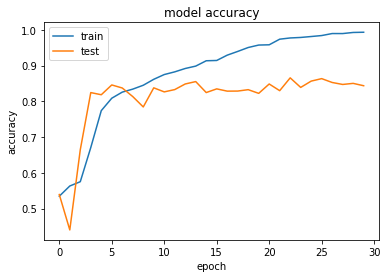

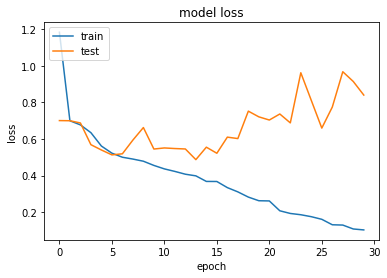

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.7058430910110474 , AUC = 0.8706525564193726 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8494210977701543
test 0.8798892870169717

-----------------------------------------------------------------


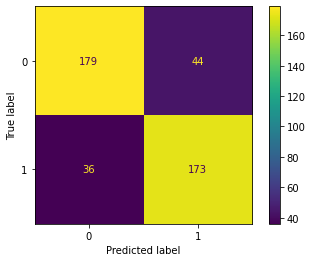

In [ ]:
# Create directory to save models
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
rt_sv_dir = '/content/models'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA_train[RUN]['MFCCS'][:]
  textra    = DATA_train[RUN]['EXTRA'][:]
  timgs     = DATA_train[RUN]['MEL'][:]
  labels    = DATA_train[RUN]['LABELS'][:]

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  val_features= DATA_val[RUN]['MFCCS'][:]
  val_extra   = DATA_val[RUN]['EXTRA'][:]
  val_imgs    = DATA_val[RUN]['MEL'][:]
  val_labels  = DATA_val[RUN]['LABELS'][ :]


  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=30,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.show()

0
Num_samples: 432
acc:  0.8148148148148148


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


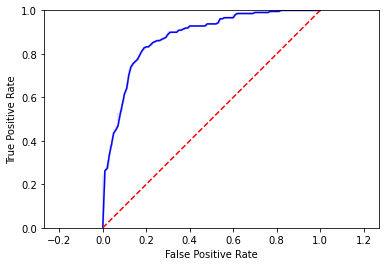

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/030--0.840--0.103.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

##9 epoch

rm: cannot remove '/content/models/9epoch': No such file or directory


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5904159519725557


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5861994979294955
77/77 - 20s - loss: 1.1831 - auc: 0.5310 - val_loss: 0.6942 - val_auc: 0.5887 - 20s/epoch - 261ms/step
Epoch 2/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.523606346483705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5148797390949857
77/77 - 16s - loss: 0.7048 - auc: 0.5722 - val_loss: 0.7128 - val_auc: 0.5238 - 16s/epoch - 212ms/step
Epoch 3/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7393867924528302


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7639624949041991
77/77 - 16s - loss: 0.6671 - auc: 0.6067 - val_loss: 0.7729 - val_auc: 0.7381 - 16s/epoch - 206ms/step
Epoch 4/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8013078902229845


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7991503422232712
77/77 - 16s - loss: 0.5936 - auc: 0.7248 - val_loss: 0.7216 - val_auc: 0.8009 - 16s/epoch - 206ms/step
Epoch 5/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8113636363636363


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8288025403909285
77/77 - 16s - loss: 0.5397 - auc: 0.7928 - val_loss: 0.5420 - val_auc: 0.8108 - 16s/epoch - 204ms/step
Epoch 6/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8425171526586621


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8492286566395605
77/77 - 16s - loss: 0.5180 - auc: 0.8169 - val_loss: 0.4972 - val_auc: 0.8420 - 16s/epoch - 206ms/step
Epoch 7/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8476843910806175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8421267191623577
77/77 - 16s - loss: 0.4996 - auc: 0.8319 - val_loss: 0.5156 - val_auc: 0.8482 - 16s/epoch - 205ms/step
Epoch 8/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8323970840480274


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8263565558821635
77/77 - 16s - loss: 0.4841 - auc: 0.8407 - val_loss: 0.5413 - val_auc: 0.8317 - 16s/epoch - 204ms/step
Epoch 9/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8449828473413379


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8330722852790353
77/77 - 16s - loss: 0.4750 - auc: 0.8457 - val_loss: 0.5070 - val_auc: 0.8451 - 16s/epoch - 206ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


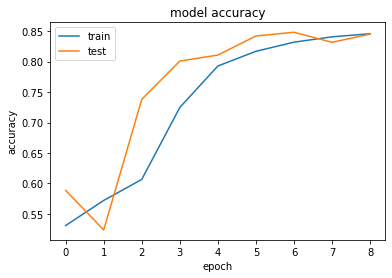

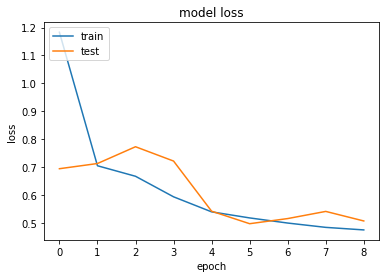

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5165619254112244 , AUC = 0.8331366181373596 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8449828473413379
test 0.8330722852790353

-----------------------------------------------------------------


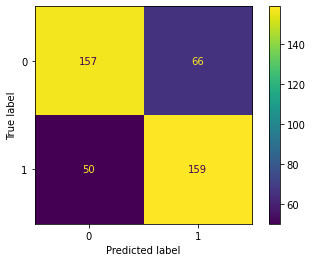

In [ ]:
# Create directory to save models
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
rt_sv_dir = '/content/models/9epoch'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA_train[RUN]['MFCCS'][:]
  textra    = DATA_train[RUN]['EXTRA'][:]
  timgs     = DATA_train[RUN]['MEL'][:]
  labels    = DATA_train[RUN]['LABELS'][:]

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  val_features= DATA_val[RUN]['MFCCS'][:]
  val_extra   = DATA_val[RUN]['EXTRA'][:]
  val_imgs    = DATA_val[RUN]['MEL'][:]
  val_labels  = DATA_val[RUN]['LABELS'][ :]


  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=9,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.show()

0
Num_samples: 432
acc:  0.7314814814814815


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


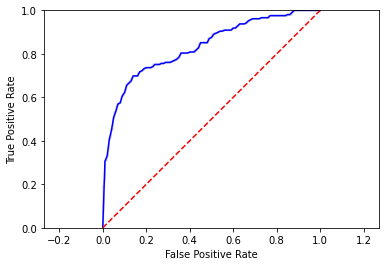

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/9epoch/0/009--0.507--0.475.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

##50 epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5891938250428816


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6168386723024439
77/77 - 21s - loss: 1.1382 - auc: 0.5211 - val_loss: 0.6872 - val_auc: 0.5881 - 21s/epoch - 272ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7524442538593482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7611946703284914
77/77 - 18s - loss: 0.7052 - auc: 0.5828 - val_loss: 0.6810 - val_auc: 0.7501 - 18s/epoch - 233ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.781367924528302


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7809556504387754
77/77 - 16s - loss: 0.6417 - auc: 0.6632 - val_loss: 0.6136 - val_auc: 0.7810 - 16s/epoch - 214ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8239065180102916


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.816379513806939
77/77 - 16s - loss: 0.5556 - auc: 0.7792 - val_loss: 0.5698 - val_auc: 0.8249 - 16s/epoch - 206ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8216123499142366


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8340807174887894
77/77 - 16s - loss: 0.5290 - auc: 0.8049 - val_loss: 0.5500 - val_auc: 0.8222 - 16s/epoch - 205ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8289451114922815


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8317420130023387
77/77 - 18s - loss: 0.5118 - auc: 0.8217 - val_loss: 0.5629 - val_auc: 0.8293 - 18s/epoch - 240ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8349485420240137


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8421910871757461
77/77 - 16s - loss: 0.5072 - auc: 0.8241 - val_loss: 0.5020 - val_auc: 0.8349 - 16s/epoch - 205ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.767066895368782


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7800544982513357
77/77 - 17s - loss: 0.4825 - auc: 0.8426 - val_loss: 0.5848 - val_auc: 0.7665 - 17s/epoch - 220ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8430960548885077


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8364837899886284
77/77 - 18s - loss: 0.4828 - auc: 0.8442 - val_loss: 0.5000 - val_auc: 0.8428 - 18s/epoch - 236ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8401586620926242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8491642886261721
77/77 - 16s - loss: 0.4624 - auc: 0.8578 - val_loss: 0.4892 - val_auc: 0.8404 - 16s/epoch - 211ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8452830188679246


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8441221275774026
77/77 - 16s - loss: 0.4504 - auc: 0.8651 - val_loss: 0.4901 - val_auc: 0.8450 - 16s/epoch - 205ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8313464837049742


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8375780462162337
77/77 - 16s - loss: 0.4191 - auc: 0.8861 - val_loss: 0.5296 - val_auc: 0.8311 - 16s/epoch - 206ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8458833619210978


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8509451369965885
77/77 - 16s - loss: 0.4122 - auc: 0.8887 - val_loss: 0.5721 - val_auc: 0.8455 - 16s/epoch - 207ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7878644939965695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7879717638981268
77/77 - 16s - loss: 0.3923 - auc: 0.9007 - val_loss: 0.5898 - val_auc: 0.7873 - 16s/epoch - 206ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8300600343053174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8375780462162337
77/77 - 17s - loss: 0.3889 - auc: 0.9025 - val_loss: 0.5528 - val_auc: 0.8292 - 17s/epoch - 221ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8240780445969126


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8130538331151973
77/77 - 16s - loss: 0.3829 - auc: 0.9059 - val_loss: 0.6691 - val_auc: 0.8222 - 16s/epoch - 207ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8418096054888506


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8380071663054905
77/77 - 16s - loss: 0.3464 - auc: 0.9239 - val_loss: 0.5703 - val_auc: 0.8418 - 16s/epoch - 209ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7871783876500857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.832965005256721
77/77 - 16s - loss: 0.3282 - auc: 0.9324 - val_loss: 0.8471 - val_auc: 0.7833 - 16s/epoch - 212ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.848156089193825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8468899521531101
77/77 - 16s - loss: 0.2974 - auc: 0.9451 - val_loss: 0.6517 - val_auc: 0.8469 - 16s/epoch - 206ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8371247855917666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8364623339841655
77/77 - 16s - loss: 0.2877 - auc: 0.9483 - val_loss: 0.6979 - val_auc: 0.8344 - 16s/epoch - 205ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8146869639794168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8273006200785289
77/77 - 16s - loss: 0.2636 - auc: 0.9571 - val_loss: 0.6732 - val_auc: 0.8132 - 16s/epoch - 208ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8383576329331046


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8400669427339241
77/77 - 16s - loss: 0.2479 - auc: 0.9621 - val_loss: 0.8668 - val_auc: 0.8347 - 16s/epoch - 211ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8318717838765007


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.85826163451842
77/77 - 16s - loss: 0.2295 - auc: 0.9675 - val_loss: 0.8818 - val_auc: 0.8276 - 16s/epoch - 209ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8339193825042881


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8375780462162336
77/77 - 17s - loss: 0.2056 - auc: 0.9744 - val_loss: 0.8309 - val_auc: 0.8299 - 17s/epoch - 222ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8189965694682675


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8157572896775163
77/77 - 16s - loss: 0.1837 - auc: 0.9792 - val_loss: 1.0431 - val_auc: 0.8077 - 16s/epoch - 207ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8555531732418525


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8501083528225374
77/77 - 16s - loss: 0.1739 - auc: 0.9813 - val_loss: 0.7774 - val_auc: 0.8529 - 16s/epoch - 209ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8505574614065181


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8736348617160512
77/77 - 16s - loss: 0.1378 - auc: 0.9884 - val_loss: 0.8658 - val_auc: 0.8507 - 16s/epoch - 208ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8415094339622642


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.879138326860772
77/77 - 16s - loss: 0.1390 - auc: 0.9879 - val_loss: 0.8975 - val_auc: 0.8359 - 16s/epoch - 205ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8497534305317325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8757911901645676
77/77 - 16s - loss: 0.1227 - auc: 0.9908 - val_loss: 1.0023 - val_auc: 0.8465 - 16s/epoch - 210ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8424313893653516


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8695260368614157
77/77 - 16s - loss: 0.1181 - auc: 0.9912 - val_loss: 1.1614 - val_auc: 0.8236 - 16s/epoch - 210ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8476843910806175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8645589718282662
77/77 - 16s - loss: 0.1090 - auc: 0.9923 - val_loss: 1.0019 - val_auc: 0.8402 - 16s/epoch - 205ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8569146655231561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8545604737485785
77/77 - 16s - loss: 0.0894 - auc: 0.9946 - val_loss: 0.9725 - val_auc: 0.8515 - 16s/epoch - 205ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.847545025728988


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8718003733344777
77/77 - 16s - loss: 0.0564 - auc: 0.9982 - val_loss: 1.1834 - val_auc: 0.8441 - 16s/epoch - 203ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8542881646655233


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8776578625528355
77/77 - 16s - loss: 0.0679 - auc: 0.9969 - val_loss: 1.0720 - val_auc: 0.8520 - 16s/epoch - 204ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8533126072041166


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8703628210354668
77/77 - 16s - loss: 0.0618 - auc: 0.9970 - val_loss: 1.1999 - val_auc: 0.8490 - 16s/epoch - 205ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8527015437392795


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8719720213701804
77/77 - 17s - loss: 0.0623 - auc: 0.9971 - val_loss: 1.2465 - val_auc: 0.8456 - 17s/epoch - 214ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8555531732418524


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8809835432445771
77/77 - 16s - loss: 0.0494 - auc: 0.9980 - val_loss: 1.0656 - val_auc: 0.8474 - 16s/epoch - 203ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8591337907375644


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8750831420172935
77/77 - 16s - loss: 0.0659 - auc: 0.9968 - val_loss: 1.0610 - val_auc: 0.8471 - 16s/epoch - 204ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.857032590051458


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8794601669277147
77/77 - 16s - loss: 0.0498 - auc: 0.9983 - val_loss: 1.2287 - val_auc: 0.8453 - 16s/epoch - 211ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8517581475128646


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8740425258008453
77/77 - 16s - loss: 0.0492 - auc: 0.9980 - val_loss: 1.0450 - val_auc: 0.8456 - 16s/epoch - 204ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.870368782161235


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8835046237689617
77/77 - 16s - loss: 0.0443 - auc: 0.9985 - val_loss: 1.2023 - val_auc: 0.8619 - 16s/epoch - 204ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8411878216123501


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8750616860128307
77/77 - 16s - loss: 0.0442 - auc: 0.9986 - val_loss: 1.2571 - val_auc: 0.8237 - 16s/epoch - 207ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8833404802744426


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8916579054648444
77/77 - 16s - loss: 0.0687 - auc: 0.9962 - val_loss: 1.0440 - val_auc: 0.8768 - 16s/epoch - 210ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8525300171526586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8735061256892742
77/77 - 16s - loss: 0.0493 - auc: 0.9981 - val_loss: 1.3701 - val_auc: 0.8414 - 16s/epoch - 214ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8680853344768439


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.876434870298453
77/77 - 17s - loss: 0.0238 - auc: 0.9996 - val_loss: 1.3765 - val_auc: 0.8467 - 17s/epoch - 215ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8564215265866209


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.86955822086811
77/77 - 17s - loss: 0.0367 - auc: 0.9988 - val_loss: 1.5099 - val_auc: 0.8437 - 17s/epoch - 215ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8680531732418525


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8820992554766451
77/77 - 16s - loss: 0.0402 - auc: 0.9990 - val_loss: 1.3511 - val_auc: 0.8580 - 16s/epoch - 208ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8622534305317324


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.904209668075611
77/77 - 16s - loss: 0.0535 - auc: 0.9974 - val_loss: 1.1765 - val_auc: 0.8489 - 16s/epoch - 207ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8639686963979416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9046817001737937
77/77 - 16s - loss: 0.0181 - auc: 0.9995 - val_loss: 1.4058 - val_auc: 0.8525 - 16s/epoch - 206ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8605917667238422


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9052931963009848
77/77 - 16s - loss: 0.0153 - auc: 0.9996 - val_loss: 1.4952 - val_auc: 0.8537 - 16s/epoch - 208ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


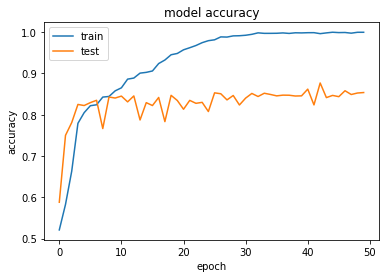

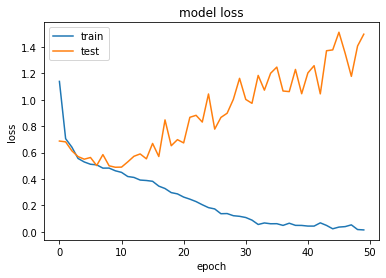

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.0332732200622559 , AUC = 0.8867766857147217 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8605917667238422
test 0.9052931963009848

-----------------------------------------------------------------


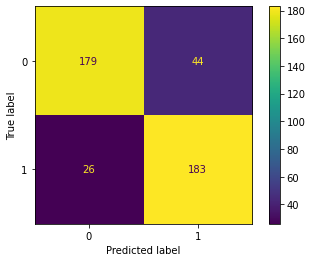

In [ ]:
# Create directory to save models
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
rt_sv_dir = '/content/models/9epoch'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA_train[RUN]['MFCCS'][:]
  textra    = DATA_train[RUN]['EXTRA'][:]
  timgs     = DATA_train[RUN]['MEL'][:]
  labels    = DATA_train[RUN]['LABELS'][:]

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  val_features= DATA_val[RUN]['MFCCS'][:]
  val_extra   = DATA_val[RUN]['EXTRA'][:]
  val_imgs    = DATA_val[RUN]['MEL'][:]
  val_labels  = DATA_val[RUN]['LABELS'][ :]


  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=50,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.show()

0
Num_samples: 432
acc:  0.8379629629629629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


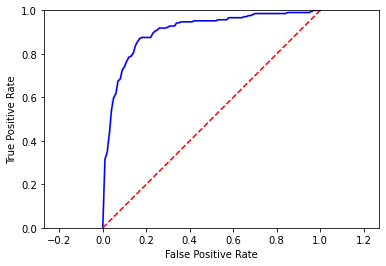

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/9epoch/0/050--1.495--0.015.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

##100 epoch(0.01 LR)

rm: cannot remove '/content/models/100epoch': No such file or directory
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5662628644939965


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5749350955864999
77/77 - 17s - loss: 2.0591 - auc: 0.5265 - val_loss: 0.6591 - val_auc: 0.5663 - 17s/epoch - 224ms/step
Epoch 2/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7673670668953687


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7728023687428927
77/77 - 15s - loss: 0.6542 - auc: 0.6218 - val_loss: 0.5779 - val_auc: 0.7686 - 15s/epoch - 201ms/step
Epoch 3/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7735205831903945


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7742506490441351
77/77 - 15s - loss: 0.5646 - auc: 0.7598 - val_loss: 0.5578 - val_auc: 0.7695 - 15s/epoch - 201ms/step
Epoch 4/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7820325900514579


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7853863153603536
77/77 - 16s - loss: 0.5612 - auc: 0.7691 - val_loss: 0.5207 - val_auc: 0.7820 - 16s/epoch - 204ms/step
Epoch 5/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7808319039451115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7965327096788035
77/77 - 16s - loss: 0.5542 - auc: 0.7835 - val_loss: 0.5414 - val_auc: 0.7809 - 16s/epoch - 205ms/step
Epoch 6/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7945325900514579


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7888085480721779
77/77 - 16s - loss: 0.5532 - auc: 0.7689 - val_loss: 0.5811 - val_auc: 0.7950 - 16s/epoch - 203ms/step
Epoch 7/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8139794168096055


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8099641684725472
77/77 - 16s - loss: 0.5426 - auc: 0.7963 - val_loss: 0.5417 - val_auc: 0.8148 - 16s/epoch - 208ms/step
Epoch 8/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8401157804459691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8330722852790352
77/77 - 16s - loss: 0.5318 - auc: 0.8019 - val_loss: 0.5325 - val_auc: 0.8406 - 16s/epoch - 204ms/step
Epoch 9/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8223842195540308


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8136760572446199
77/77 - 16s - loss: 0.5094 - auc: 0.8207 - val_loss: 0.5385 - val_auc: 0.8219 - 16s/epoch - 204ms/step
Epoch 10/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8467838765008576


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8335121333705238
77/77 - 16s - loss: 0.5055 - auc: 0.8215 - val_loss: 0.5014 - val_auc: 0.8468 - 16s/epoch - 202ms/step
Epoch 11/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8041166380789023


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7911901645675542
77/77 - 15s - loss: 0.5113 - auc: 0.8227 - val_loss: 0.5275 - val_auc: 0.8050 - 15s/epoch - 200ms/step
Epoch 12/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8408447684391082


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8388332224773103
77/77 - 15s - loss: 0.5017 - auc: 0.8284 - val_loss: 0.5223 - val_auc: 0.8410 - 15s/epoch - 201ms/step
Epoch 13/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8238850771869641


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8197373785053748
77/77 - 15s - loss: 0.4816 - auc: 0.8398 - val_loss: 0.5209 - val_auc: 0.8236 - 15s/epoch - 201ms/step
Epoch 14/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.801114922813036


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.808118952088742
77/77 - 16s - loss: 0.4655 - auc: 0.8511 - val_loss: 0.5540 - val_auc: 0.8017 - 16s/epoch - 204ms/step
Epoch 15/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8519403945111492


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.83958418263351
77/77 - 16s - loss: 0.4681 - auc: 0.8522 - val_loss: 0.5013 - val_auc: 0.8514 - 16s/epoch - 204ms/step
Epoch 16/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.833040308747856


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8402815027785526
77/77 - 15s - loss: 0.4707 - auc: 0.8524 - val_loss: 0.5126 - val_auc: 0.8329 - 15s/epoch - 201ms/step
Epoch 17/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7639150943396226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7721157766000815
77/77 - 15s - loss: 0.4657 - auc: 0.8531 - val_loss: 0.7352 - val_auc: 0.7628 - 15s/epoch - 200ms/step
Epoch 18/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8435141509433963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8339090694530864
77/77 - 15s - loss: 0.4578 - auc: 0.8594 - val_loss: 0.4980 - val_auc: 0.8445 - 15s/epoch - 200ms/step
Epoch 19/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7809391080617495


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7806016263651383
77/77 - 15s - loss: 0.4439 - auc: 0.8680 - val_loss: 0.6771 - val_auc: 0.7802 - 15s/epoch - 200ms/step
Epoch 20/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8201222126929674


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8232776192417448
77/77 - 15s - loss: 0.4363 - auc: 0.8719 - val_loss: 0.5694 - val_auc: 0.8200 - 15s/epoch - 201ms/step
Epoch 21/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8412843053173242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8463964640504646
77/77 - 15s - loss: 0.4444 - auc: 0.8678 - val_loss: 0.5025 - val_auc: 0.8415 - 15s/epoch - 201ms/step
Epoch 22/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7639686963979417


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7754521852940546
77/77 - 16s - loss: 0.4369 - auc: 0.8742 - val_loss: 0.9489 - val_auc: 0.7592 - 16s/epoch - 203ms/step
Epoch 23/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8445647512864494


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8423520072092174
77/77 - 15s - loss: 0.4123 - auc: 0.8844 - val_loss: 0.5017 - val_auc: 0.8436 - 15s/epoch - 200ms/step
Epoch 24/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.783426243567753


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8067886798120454
77/77 - 15s - loss: 0.4050 - auc: 0.8912 - val_loss: 0.6813 - val_auc: 0.7828 - 15s/epoch - 198ms/step
Epoch 25/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8525300171526586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8480593043963353
77/77 - 15s - loss: 0.4035 - auc: 0.8914 - val_loss: 0.4986 - val_auc: 0.8525 - 15s/epoch - 200ms/step
Epoch 26/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8479845626072041


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8665865642500055
77/77 - 15s - loss: 0.3927 - auc: 0.8985 - val_loss: 0.5452 - val_auc: 0.8480 - 15s/epoch - 200ms/step
Epoch 27/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8218481989708405


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8314309009376274
77/77 - 15s - loss: 0.3825 - auc: 0.9034 - val_loss: 0.6223 - val_auc: 0.8217 - 15s/epoch - 200ms/step
Epoch 28/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8298456260720412


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8439504795416998
77/77 - 15s - loss: 0.3767 - auc: 0.9069 - val_loss: 0.5857 - val_auc: 0.8293 - 15s/epoch - 200ms/step
Epoch 29/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.815673241852487


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8339090694530864
77/77 - 16s - loss: 0.3734 - auc: 0.9080 - val_loss: 0.5792 - val_auc: 0.8138 - 16s/epoch - 202ms/step
Epoch 30/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8348413379073756


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8495075846975776
77/77 - 16s - loss: 0.3765 - auc: 0.9080 - val_loss: 0.5205 - val_auc: 0.8353 - 16s/epoch - 204ms/step
Epoch 31/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8275943396226415


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8525972493402278
77/77 - 15s - loss: 0.3550 - auc: 0.9184 - val_loss: 0.5378 - val_auc: 0.8274 - 15s/epoch - 198ms/step
Epoch 32/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8457868782161235


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8769069023966357
77/77 - 15s - loss: 0.3306 - auc: 0.9280 - val_loss: 0.5165 - val_auc: 0.8455 - 15s/epoch - 199ms/step
Epoch 33/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8428602058319038


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8546784817731242
77/77 - 15s - loss: 0.3204 - auc: 0.9328 - val_loss: 0.5848 - val_auc: 0.8401 - 15s/epoch - 199ms/step
Epoch 34/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8331046312178386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8575643143733773
77/77 - 16s - loss: 0.3255 - auc: 0.9323 - val_loss: 0.5706 - val_auc: 0.8319 - 16s/epoch - 201ms/step
Epoch 35/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8429888507718695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8553114339047782
77/77 - 16s - loss: 0.2971 - auc: 0.9428 - val_loss: 0.5975 - val_auc: 0.8420 - 16s/epoch - 204ms/step
Epoch 36/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8204331046312179


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8496363207243547
77/77 - 15s - loss: 0.3143 - auc: 0.9361 - val_loss: 0.6509 - val_auc: 0.8168 - 15s/epoch - 198ms/step
Epoch 37/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8106989708404803


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8534233055120476
77/77 - 15s - loss: 0.2759 - auc: 0.9513 - val_loss: 0.8164 - val_auc: 0.8064 - 15s/epoch - 199ms/step
Epoch 38/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8408018867924528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8561482180788293
77/77 - 15s - loss: 0.2756 - auc: 0.9501 - val_loss: 0.6486 - val_auc: 0.8379 - 15s/epoch - 198ms/step
Epoch 39/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8616209262435677


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8755659021177077
77/77 - 15s - loss: 0.2603 - auc: 0.9567 - val_loss: 0.5994 - val_auc: 0.8599 - 15s/epoch - 198ms/step
Epoch 40/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8254288164665524


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8480163923874096
77/77 - 15s - loss: 0.2681 - auc: 0.9541 - val_loss: 0.7243 - val_auc: 0.8246 - 15s/epoch - 200ms/step
Epoch 41/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8510077186963979


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8737206857339026
77/77 - 15s - loss: 0.2612 - auc: 0.9575 - val_loss: 0.5997 - val_auc: 0.8503 - 15s/epoch - 200ms/step
Epoch 42/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8250643224699828


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8632716115604953
77/77 - 15s - loss: 0.2565 - auc: 0.9585 - val_loss: 0.6724 - val_auc: 0.8234 - 15s/epoch - 199ms/step
Epoch 43/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.848048885077187


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8682494045958761
77/77 - 15s - loss: 0.2500 - auc: 0.9616 - val_loss: 0.6191 - val_auc: 0.8440 - 15s/epoch - 201ms/step
Epoch 44/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8429459691252144


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8833007917265647
77/77 - 16s - loss: 0.2514 - auc: 0.9609 - val_loss: 0.7116 - val_auc: 0.8422 - 16s/epoch - 210ms/step
Epoch 45/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8507182675814751


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8835904477868131
77/77 - 16s - loss: 0.2397 - auc: 0.9643 - val_loss: 0.6858 - val_auc: 0.8469 - 16s/epoch - 211ms/step
Epoch 46/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8257718696397941


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8732808376424142
77/77 - 16s - loss: 0.2078 - auc: 0.9736 - val_loss: 0.7871 - val_auc: 0.8227 - 16s/epoch - 204ms/step
Epoch 47/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8415415951972556


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8709528611581951
77/77 - 16s - loss: 0.1883 - auc: 0.9779 - val_loss: 0.6875 - val_auc: 0.8387 - 16s/epoch - 204ms/step
Epoch 48/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8173241852487135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.859345162743794
77/77 - 16s - loss: 0.1742 - auc: 0.9810 - val_loss: 0.8227 - val_auc: 0.8130 - 16s/epoch - 202ms/step
Epoch 49/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8548777873070326


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8832793357221018
77/77 - 16s - loss: 0.1871 - auc: 0.9780 - val_loss: 0.6980 - val_auc: 0.8532 - 16s/epoch - 207ms/step
Epoch 50/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8317431389365352


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8634539875984294
77/77 - 16s - loss: 0.1793 - auc: 0.9802 - val_loss: 0.8525 - val_auc: 0.8258 - 16s/epoch - 205ms/step
Epoch 51/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8517474271012008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8873559765700432
77/77 - 16s - loss: 0.1504 - auc: 0.9858 - val_loss: 0.8069 - val_auc: 0.8447 - 16s/epoch - 203ms/step
Epoch 52/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8620926243567753


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8868946724740918
77/77 - 16s - loss: 0.1451 - auc: 0.9867 - val_loss: 0.8800 - val_auc: 0.8566 - 16s/epoch - 203ms/step
Epoch 53/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8591123499142366


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8948226661231146
77/77 - 15s - loss: 0.1405 - auc: 0.9877 - val_loss: 1.0732 - val_auc: 0.8553 - 15s/epoch - 199ms/step
Epoch 54/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8708940823327616


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9043705881090823
77/77 - 16s - loss: 0.1336 - auc: 0.9888 - val_loss: 0.7110 - val_auc: 0.8638 - 16s/epoch - 203ms/step
Epoch 55/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.836159948542024


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8564807861480035
77/77 - 16s - loss: 0.1311 - auc: 0.9894 - val_loss: 1.5839 - val_auc: 0.8277 - 16s/epoch - 205ms/step
Epoch 56/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8711406518010292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.884824168043427
77/77 - 16s - loss: 0.1503 - auc: 0.9859 - val_loss: 0.6927 - val_auc: 0.8663 - 16s/epoch - 204ms/step
Epoch 57/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.868364065180103


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8997253631428755
77/77 - 16s - loss: 0.1202 - auc: 0.9904 - val_loss: 0.7794 - val_auc: 0.8636 - 16s/epoch - 204ms/step
Epoch 58/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8819039451114923


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8944364580427833
77/77 - 16s - loss: 0.1212 - auc: 0.9908 - val_loss: 0.7370 - val_auc: 0.8791 - 16s/epoch - 207ms/step
Epoch 59/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.868803602058319


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9051000922608191
77/77 - 16s - loss: 0.1228 - auc: 0.9904 - val_loss: 0.8755 - val_auc: 0.8655 - 16s/epoch - 206ms/step
Epoch 60/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8516723842195539


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8970755465917137
77/77 - 16s - loss: 0.1030 - auc: 0.9923 - val_loss: 1.0110 - val_auc: 0.8514 - 16s/epoch - 204ms/step
Epoch 61/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8798241852487136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.899639539125024
77/77 - 15s - loss: 0.1150 - auc: 0.9919 - val_loss: 0.8869 - val_auc: 0.8705 - 15s/epoch - 200ms/step
Epoch 62/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8691252144082333


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9045636921492479
77/77 - 15s - loss: 0.1146 - auc: 0.9913 - val_loss: 0.9428 - val_auc: 0.8612 - 15s/epoch - 200ms/step
Epoch 63/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8670883361921098


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9032656038792455
77/77 - 16s - loss: 0.0896 - auc: 0.9943 - val_loss: 0.9241 - val_auc: 0.8621 - 16s/epoch - 214ms/step
Epoch 64/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8739065180102916


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8895659450297166
77/77 - 16s - loss: 0.0785 - auc: 0.9960 - val_loss: 0.9475 - val_auc: 0.8667 - 16s/epoch - 204ms/step
Epoch 65/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8545990566037734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8913360653979016
77/77 - 16s - loss: 0.1084 - auc: 0.9924 - val_loss: 0.9938 - val_auc: 0.8465 - 16s/epoch - 202ms/step
Epoch 66/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8392045454545455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8890295449181455
77/77 - 15s - loss: 0.0884 - auc: 0.9947 - val_loss: 1.4642 - val_auc: 0.8271 - 15s/epoch - 198ms/step
Epoch 67/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8320433104631217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8808762632222628
77/77 - 15s - loss: 0.0850 - auc: 0.9948 - val_loss: 1.1888 - val_auc: 0.8195 - 15s/epoch - 201ms/step
Epoch 68/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8327508576329332


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8949835861565859
77/77 - 16s - loss: 0.0807 - auc: 0.9957 - val_loss: 1.2063 - val_auc: 0.8233 - 16s/epoch - 203ms/step
Epoch 69/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8618460548885076


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9075246207651211
77/77 - 16s - loss: 0.0719 - auc: 0.9965 - val_loss: 1.0573 - val_auc: 0.8553 - 16s/epoch - 203ms/step
Epoch 70/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8481239279588335


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8801682150749888
77/77 - 15s - loss: 0.0821 - auc: 0.9954 - val_loss: 1.1286 - val_auc: 0.8350 - 15s/epoch - 200ms/step
Epoch 71/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8575793310463122


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8979659707769221
77/77 - 15s - loss: 0.0796 - auc: 0.9950 - val_loss: 1.1596 - val_auc: 0.8525 - 15s/epoch - 198ms/step
Epoch 72/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8756217838765008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9006694273392409
77/77 - 16s - loss: 0.0809 - auc: 0.9947 - val_loss: 0.9272 - val_auc: 0.8727 - 16s/epoch - 202ms/step
Epoch 73/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8626179245283019


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8954019782436115
77/77 - 16s - loss: 0.1021 - auc: 0.9931 - val_loss: 0.9821 - val_auc: 0.8556 - 16s/epoch - 203ms/step
Epoch 74/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8749035162950257


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9091981891132234
77/77 - 16s - loss: 0.0755 - auc: 0.9961 - val_loss: 0.9769 - val_auc: 0.8638 - 16s/epoch - 205ms/step
Epoch 75/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8780660377358491


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9049928122385049
77/77 - 15s - loss: 0.0686 - auc: 0.9964 - val_loss: 1.0330 - val_auc: 0.8693 - 15s/epoch - 200ms/step
Epoch 76/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8402980274442539


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8781406226532495
77/77 - 16s - loss: 0.0774 - auc: 0.9959 - val_loss: 1.8295 - val_auc: 0.8220 - 16s/epoch - 203ms/step
Epoch 77/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8530981989708405


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.89539125024138
77/77 - 16s - loss: 0.0732 - auc: 0.9960 - val_loss: 0.8599 - val_auc: 0.8486 - 16s/epoch - 206ms/step
Epoch 78/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8739065180102916


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9024824597163517
77/77 - 16s - loss: 0.0691 - auc: 0.9965 - val_loss: 1.3748 - val_auc: 0.8635 - 16s/epoch - 204ms/step
Epoch 79/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8566788164665524


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8906816572617846
77/77 - 16s - loss: 0.0685 - auc: 0.9957 - val_loss: 1.5277 - val_auc: 0.8484 - 16s/epoch - 202ms/step
Epoch 80/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8588872212692966


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8904563692149248
77/77 - 15s - loss: 0.0512 - auc: 0.9978 - val_loss: 1.3622 - val_auc: 0.8468 - 15s/epoch - 200ms/step
Epoch 81/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.858930102915952


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8998970111785782
77/77 - 15s - loss: 0.0623 - auc: 0.9969 - val_loss: 1.1114 - val_auc: 0.8483 - 15s/epoch - 201ms/step
Epoch 82/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8457761578044598


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8799536550303602
77/77 - 15s - loss: 0.0721 - auc: 0.9954 - val_loss: 1.1203 - val_auc: 0.8354 - 15s/epoch - 198ms/step
Epoch 83/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8576007718696397


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9008947153861008
77/77 - 15s - loss: 0.0654 - auc: 0.9964 - val_loss: 0.8396 - val_auc: 0.8519 - 15s/epoch - 201ms/step
Epoch 84/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8449721269296742


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8981483468148561
77/77 - 16s - loss: 0.0623 - auc: 0.9971 - val_loss: 1.0924 - val_auc: 0.8323 - 16s/epoch - 202ms/step
Epoch 85/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8639579759862779


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8996824511339498
77/77 - 15s - loss: 0.0795 - auc: 0.9954 - val_loss: 0.9129 - val_auc: 0.8533 - 15s/epoch - 201ms/step
Epoch 86/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8570647512864494


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8797498229879631
77/77 - 15s - loss: 0.0779 - auc: 0.9960 - val_loss: 0.8799 - val_auc: 0.8492 - 15s/epoch - 199ms/step
Epoch 87/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8734240994854203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9080395648722295
77/77 - 15s - loss: 0.0609 - auc: 0.9970 - val_loss: 0.8769 - val_auc: 0.8628 - 15s/epoch - 200ms/step
Epoch 88/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8666380789022298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.896678610509151
77/77 - 15s - loss: 0.0447 - auc: 0.9983 - val_loss: 1.3048 - val_auc: 0.8480 - 15s/epoch - 198ms/step
Epoch 89/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8591123499142367


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8853927521616923
77/77 - 15s - loss: 0.0523 - auc: 0.9972 - val_loss: 1.2683 - val_auc: 0.8442 - 15s/epoch - 199ms/step
Epoch 90/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.875718267581475


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8937176818932777
77/77 - 15s - loss: 0.0821 - auc: 0.9947 - val_loss: 0.7997 - val_auc: 0.8675 - 15s/epoch - 199ms/step
Epoch 91/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8583297598627788


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8996073551183299
77/77 - 15s - loss: 0.0461 - auc: 0.9978 - val_loss: 1.4909 - val_auc: 0.8353 - 15s/epoch - 201ms/step
Epoch 92/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8681174957118354


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8995215311004785
77/77 - 16s - loss: 0.0500 - auc: 0.9978 - val_loss: 1.3861 - val_auc: 0.8467 - 16s/epoch - 212ms/step
Epoch 93/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8217945969125214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8743107258566309
77/77 - 17s - loss: 0.0555 - auc: 0.9974 - val_loss: 1.3495 - val_auc: 0.8037 - 17s/epoch - 216ms/step
Epoch 94/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8562392795883362


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8995966271160984
77/77 - 17s - loss: 0.0670 - auc: 0.9959 - val_loss: 1.4173 - val_auc: 0.8374 - 17s/epoch - 216ms/step
Epoch 95/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8544918524871357


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9021928036561032
77/77 - 16s - loss: 0.0664 - auc: 0.9961 - val_loss: 1.3009 - val_auc: 0.8426 - 16s/epoch - 212ms/step
Epoch 96/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8564536878216122


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9070633166691698
77/77 - 16s - loss: 0.0783 - auc: 0.9957 - val_loss: 1.5376 - val_auc: 0.8364 - 16s/epoch - 208ms/step
Epoch 97/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8815394511149228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9062050764906558
77/77 - 16s - loss: 0.0599 - auc: 0.9966 - val_loss: 0.9359 - val_auc: 0.8782 - 16s/epoch - 212ms/step
Epoch 98/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8500536020583189


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8896839530542623
77/77 - 16s - loss: 0.0434 - auc: 0.9975 - val_loss: 1.2122 - val_auc: 0.8406 - 16s/epoch - 213ms/step
Epoch 99/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8542667238421955


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8834080717488788
77/77 - 17s - loss: 0.0450 - auc: 0.9980 - val_loss: 1.2366 - val_auc: 0.8456 - 17s/epoch - 218ms/step
Epoch 100/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8546419382504289


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8931169137683181
77/77 - 17s - loss: 0.0463 - auc: 0.9978 - val_loss: 1.5330 - val_auc: 0.8377 - 17s/epoch - 216ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


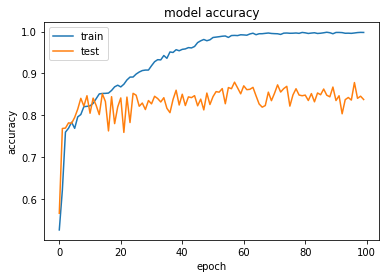

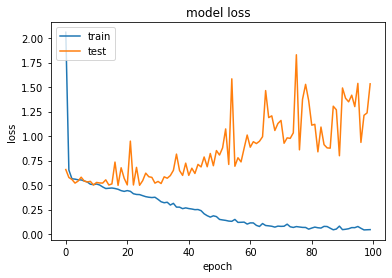

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.3508416414260864 , AUC = 0.8791598081588745 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8546419382504289
test 0.8931169137683181

-----------------------------------------------------------------


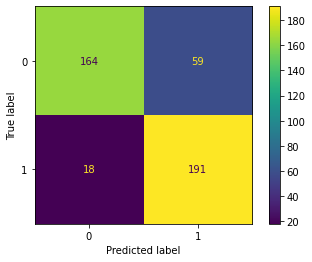

In [ ]:
# Create directory to save models
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
rt_sv_dir = '/content/models/100epoch'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()
  optimizer = keras.optimizers.Adam(lr=0.01)
  MERGM.compile(
      optimizer = optimizer,
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA_train[RUN]['MFCCS'][:]
  textra    = DATA_train[RUN]['EXTRA'][:]
  timgs     = DATA_train[RUN]['MEL'][:]
  labels    = DATA_train[RUN]['LABELS'][:]

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  val_features= DATA_val[RUN]['MFCCS'][:]
  val_extra   = DATA_val[RUN]['EXTRA'][:]
  val_imgs    = DATA_val[RUN]['MEL'][:]
  val_labels  = DATA_val[RUN]['LABELS'][ :]


  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=100,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.show()

0
Num_samples: 432
acc:  0.8217592592592593


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


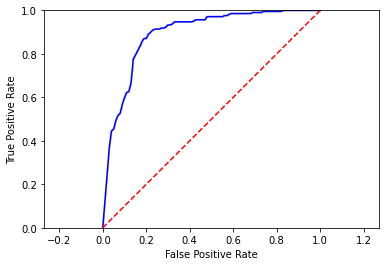

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/100epoch/0/100--1.533--0.046.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

## try 50 epoch(augmantation in train and validation only)

rm: cannot remove '/content/models': No such file or directory


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6394244172331711


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5458372712432339
77/77 - 18s - loss: 1.2378 - auc: 0.5309 - val_loss: 0.6970 - val_auc: 0.6383 - 18s/epoch - 232ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.443267354335099


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5028352951284475
77/77 - 18s - loss: 0.7110 - auc: 0.5777 - val_loss: 0.7015 - val_auc: 0.4448 - 18s/epoch - 236ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7481503720700822


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7111220895265917
77/77 - 15s - loss: 0.6817 - auc: 0.6040 - val_loss: 0.6717 - val_auc: 0.7498 - 15s/epoch - 200ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7716326049194742


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7604605206632873
77/77 - 15s - loss: 0.6486 - auc: 0.6494 - val_loss: 0.6230 - val_auc: 0.7707 - 15s/epoch - 199ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7883382299328774


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7820044677377782
77/77 - 15s - loss: 0.5546 - auc: 0.7736 - val_loss: 0.5674 - val_auc: 0.7881 - 15s/epoch - 198ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.822221269112822


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7972334392989089
77/77 - 15s - loss: 0.5145 - auc: 0.8159 - val_loss: 0.5123 - val_auc: 0.8219 - 15s/epoch - 198ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8305204692157577


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8076724804536474
77/77 - 15s - loss: 0.4992 - auc: 0.8280 - val_loss: 0.5144 - val_auc: 0.8307 - 15s/epoch - 199ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8450172631940126


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7962024228885644
77/77 - 15s - loss: 0.4985 - auc: 0.8329 - val_loss: 0.4985 - val_auc: 0.8454 - 15s/epoch - 198ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.834487787094422


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7872239883151474
77/77 - 16s - loss: 0.4835 - auc: 0.8434 - val_loss: 0.5493 - val_auc: 0.8348 - 16s/epoch - 202ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.851901095837533


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8013360254317381
77/77 - 15s - loss: 0.4796 - auc: 0.8468 - val_loss: 0.4721 - val_auc: 0.8519 - 15s/epoch - 198ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8394201282408699


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.811001804278718
77/77 - 15s - loss: 0.4620 - auc: 0.8594 - val_loss: 0.5131 - val_auc: 0.8396 - 15s/epoch - 199ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8277969591044584


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8125698084027837
77/77 - 15s - loss: 0.4510 - auc: 0.8668 - val_loss: 0.5145 - val_auc: 0.8274 - 15s/epoch - 198ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.85591130363921


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8272188332330954
77/77 - 15s - loss: 0.4422 - auc: 0.8720 - val_loss: 0.4674 - val_auc: 0.8558 - 15s/epoch - 198ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8558469687546911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8333404931695162
77/77 - 16s - loss: 0.4176 - auc: 0.8889 - val_loss: 0.4775 - val_auc: 0.8555 - 16s/epoch - 202ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8629238060517681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8442306040037805
77/77 - 16s - loss: 0.4196 - auc: 0.8868 - val_loss: 0.4725 - val_auc: 0.8630 - 16s/epoch - 202ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8585061439814716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8239969069507689
77/77 - 15s - loss: 0.4030 - auc: 0.8960 - val_loss: 0.4582 - val_auc: 0.8588 - 15s/epoch - 200ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8642748386266648


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8346077841738981
77/77 - 15s - loss: 0.3815 - auc: 0.9076 - val_loss: 0.4927 - val_auc: 0.8641 - 15s/epoch - 197ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8782140636057558


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8317724890454506
77/77 - 15s - loss: 0.3676 - auc: 0.9135 - val_loss: 0.4544 - val_auc: 0.8782 - 15s/epoch - 198ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8601359610559498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8227725749634849
77/77 - 15s - loss: 0.3507 - auc: 0.9220 - val_loss: 0.5119 - val_auc: 0.8599 - 15s/epoch - 198ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8396774677789454


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8334264112037117
77/77 - 15s - loss: 0.3280 - auc: 0.9326 - val_loss: 0.5125 - val_auc: 0.8398 - 15s/epoch - 197ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8484270120735133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8341781940029211
77/77 - 15s - loss: 0.3156 - auc: 0.9373 - val_loss: 0.6165 - val_auc: 0.8481 - 15s/epoch - 197ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8715875705003109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8468725835552883
77/77 - 16s - loss: 0.2922 - auc: 0.9465 - val_loss: 0.4549 - val_auc: 0.8716 - 16s/epoch - 205ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8760481224936201


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.836820173554429
77/77 - 15s - loss: 0.2691 - auc: 0.9548 - val_loss: 0.5713 - val_auc: 0.8739 - 15s/epoch - 198ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8815165876777251


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8329323825070883
77/77 - 15s - loss: 0.2507 - auc: 0.9609 - val_loss: 0.4850 - val_auc: 0.8805 - 15s/epoch - 197ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8759837876091012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8251138413953089
77/77 - 15s - loss: 0.2466 - auc: 0.9624 - val_loss: 0.5464 - val_auc: 0.8753 - 15s/epoch - 197ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8798009907572215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8302044849213852
77/77 - 15s - loss: 0.2149 - auc: 0.9717 - val_loss: 0.5616 - val_auc: 0.8769 - 15s/epoch - 199ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.890330466856812


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8788340922759688
77/77 - 15s - loss: 0.1896 - auc: 0.9780 - val_loss: 0.5363 - val_auc: 0.8851 - 15s/epoch - 197ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8994660204584933


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8587722312913482
77/77 - 15s - loss: 0.1810 - auc: 0.9798 - val_loss: 0.4997 - val_auc: 0.8977 - 15s/epoch - 200ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8936973258133001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8494930835982473
77/77 - 15s - loss: 0.1623 - auc: 0.9839 - val_loss: 0.5569 - val_auc: 0.8901 - 15s/epoch - 197ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8617014432459094


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8460348827218833
77/77 - 15s - loss: 0.1376 - auc: 0.9885 - val_loss: 0.6564 - val_auc: 0.8592 - 15s/epoch - 198ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8548819454869079


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8380874645588109
77/77 - 15s - loss: 0.1264 - auc: 0.9898 - val_loss: 0.9060 - val_auc: 0.8376 - 15s/epoch - 199ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8690785100040745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8231806856259127
77/77 - 15s - loss: 0.1381 - auc: 0.9882 - val_loss: 0.6650 - val_auc: 0.8655 - 15s/epoch - 198ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8731101627672578


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8454119769739669
77/77 - 15s - loss: 0.1077 - auc: 0.9924 - val_loss: 0.9018 - val_auc: 0.8553 - 15s/epoch - 199ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8790718620660075


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.841244952315491
77/77 - 15s - loss: 0.1053 - auc: 0.9921 - val_loss: 0.7550 - val_auc: 0.8692 - 15s/epoch - 198ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8712015611931977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8542722742503652
77/77 - 15s - loss: 0.0859 - auc: 0.9950 - val_loss: 0.7136 - val_auc: 0.8641 - 15s/epoch - 199ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8751045441873432


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8341567144943725
77/77 - 15s - loss: 0.0703 - auc: 0.9968 - val_loss: 0.9032 - val_auc: 0.8555 - 15s/epoch - 199ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8546246059488324


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8358965546868289
77/77 - 15s - loss: 0.0833 - auc: 0.9947 - val_loss: 1.1992 - val_auc: 0.8333 - 15s/epoch - 199ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.887349617207437


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8438224933413523
77/77 - 15s - loss: 0.0636 - auc: 0.9972 - val_loss: 0.7251 - val_auc: 0.8792 - 15s/epoch - 198ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8816238124852567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.846357075350116
77/77 - 15s - loss: 0.0631 - auc: 0.9976 - val_loss: 0.9273 - val_auc: 0.8660 - 15s/epoch - 199ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8846689970191505


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8442413437580547
77/77 - 15s - loss: 0.0504 - auc: 0.9982 - val_loss: 0.8957 - val_auc: 0.8676 - 15s/epoch - 197ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8848834466342134


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8477102843886932
77/77 - 15s - loss: 0.0557 - auc: 0.9976 - val_loss: 0.9827 - val_auc: 0.8681 - 15s/epoch - 198ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8766700263773025


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8611134977231721
77/77 - 15s - loss: 0.0548 - auc: 0.9975 - val_loss: 0.9868 - val_auc: 0.8558 - 15s/epoch - 197ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.889901567626686


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8625418850416703
77/77 - 15s - loss: 0.0607 - auc: 0.9977 - val_loss: 0.8856 - val_auc: 0.8764 - 15s/epoch - 199ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8903626342990714


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8685454076810722
77/77 - 15s - loss: 0.0496 - auc: 0.9980 - val_loss: 0.8710 - val_auc: 0.8778 - 15s/epoch - 198ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8830284574639189


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.862992954721196
77/77 - 15s - loss: 0.0303 - auc: 0.9994 - val_loss: 1.0177 - val_auc: 0.8684 - 15s/epoch - 197ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8835324140593168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8688998195721281
77/77 - 15s - loss: 0.0358 - auc: 0.9990 - val_loss: 0.9533 - val_auc: 0.8661 - 15s/epoch - 196ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8831464047522035


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.851447718876192
77/77 - 15s - loss: 0.0445 - auc: 0.9983 - val_loss: 1.0055 - val_auc: 0.8644 - 15s/epoch - 196ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8900838497994896


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8671492396253973
77/77 - 15s - loss: 0.0367 - auc: 0.9986 - val_loss: 1.0721 - val_auc: 0.8721 - 15s/epoch - 196ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8751796015526152


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8554429074662772
77/77 - 15s - loss: 0.0382 - auc: 0.9984 - val_loss: 1.4353 - val_auc: 0.8438 - 15s/epoch - 196ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8631168107053246


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8475384483203023
77/77 - 15s - loss: 0.0467 - auc: 0.9987 - val_loss: 1.1814 - val_auc: 0.8420 - 15s/epoch - 196ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


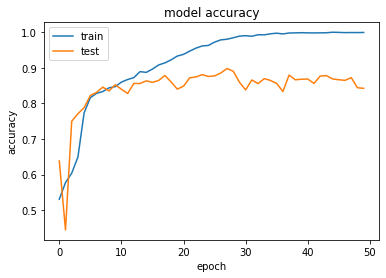

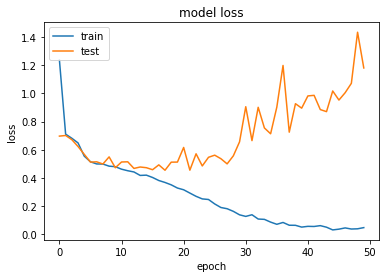

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.3655740022659302 , AUC = 0.8249098658561707 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8631168107053246
test 0.8475384483203023

-----------------------------------------------------------------


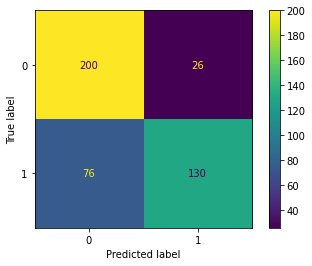

In [ ]:
# Create directory to save models
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
rt_sv_dir = '/content/models'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA_train[RUN]['MFCCS'][:]
  textra    = DATA_train[RUN]['EXTRA'][:]
  timgs     = DATA_train[RUN]['MEL'][:]
  labels    = DATA_train[RUN]['LABELS'][:]

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  val_features= DATA_val[RUN]['MFCCS'][:]
  val_extra   = DATA_val[RUN]['EXTRA'][:]
  val_imgs    = DATA_val[RUN]['MEL'][:]
  val_labels  = DATA_val[RUN]['LABELS'][ :]


  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=50,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.show()

0
Num_samples: 432
acc:  0.7638888888888888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


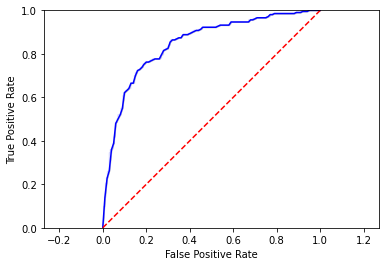

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/050--1.181--0.047.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

##20epoch

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7116724925478758


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6352564653320733
77/77 - 18s - loss: 1.4933 - auc: 0.5573 - val_loss: 0.6663 - val_auc: 0.7125 - 18s/epoch - 235ms/step
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7370204370483155


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7415800326488531
77/77 - 16s - loss: 0.6780 - auc: 0.6606 - val_loss: 0.6888 - val_auc: 0.7365 - 16s/epoch - 209ms/step
Epoch 3/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7829555445947974


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7413652375633645
77/77 - 16s - loss: 0.5661 - auc: 0.7744 - val_loss: 0.6563 - val_auc: 0.7830 - 16s/epoch - 207ms/step
Epoch 4/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.796058416075143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7872884268407939
77/77 - 16s - loss: 0.5265 - auc: 0.8122 - val_loss: 0.6178 - val_auc: 0.7955 - 16s/epoch - 209ms/step
Epoch 5/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8308421436383522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7984362917776442
77/77 - 17s - loss: 0.5191 - auc: 0.8151 - val_loss: 0.6018 - val_auc: 0.8308 - 17s/epoch - 218ms/step
Epoch 6/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8419291887371062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8110232837872671
77/77 - 17s - loss: 0.4955 - auc: 0.8368 - val_loss: 0.5048 - val_auc: 0.8419 - 17s/epoch - 218ms/step
Epoch 7/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.846732860114516


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8164146404330269
77/77 - 18s - loss: 0.4853 - auc: 0.8412 - val_loss: 0.4826 - val_auc: 0.8468 - 18s/epoch - 230ms/step
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.840235036778109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8012286278889941
77/77 - 17s - loss: 0.4708 - auc: 0.8544 - val_loss: 0.5435 - val_auc: 0.8402 - 17s/epoch - 221ms/step
Epoch 9/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8521155454525959


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8233740012028525
77/77 - 15s - loss: 0.4622 - auc: 0.8595 - val_loss: 0.4734 - val_auc: 0.8522 - 15s/epoch - 201ms/step
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8422723081212069


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7976415499613368
77/77 - 16s - loss: 0.4419 - auc: 0.8729 - val_loss: 0.6024 - val_auc: 0.8419 - 16s/epoch - 209ms/step
Epoch 11/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8485985717655636


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8206031446000515
77/77 - 15s - loss: 0.4416 - auc: 0.8743 - val_loss: 0.4744 - val_auc: 0.8487 - 15s/epoch - 198ms/step
Epoch 12/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8480838926894126


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8222785462668614
77/77 - 15s - loss: 0.4149 - auc: 0.8906 - val_loss: 0.4872 - val_auc: 0.8480 - 15s/epoch - 199ms/step
Epoch 13/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8096545216701336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7757754102586134
77/77 - 16s - loss: 0.3970 - auc: 0.8996 - val_loss: 0.7431 - val_auc: 0.8086 - 16s/epoch - 208ms/step
Epoch 14/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.849928159378954


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.839440673597388
77/77 - 15s - loss: 0.3797 - auc: 0.9095 - val_loss: 0.5150 - val_auc: 0.8498 - 15s/epoch - 199ms/step
Epoch 15/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8404923763161845


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8181759601340322
77/77 - 15s - loss: 0.3573 - auc: 0.9200 - val_loss: 0.5168 - val_auc: 0.8405 - 15s/epoch - 200ms/step
Epoch 16/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8647895177028158


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8323739152848182
77/77 - 16s - loss: 0.3267 - auc: 0.9341 - val_loss: 0.5098 - val_auc: 0.8647 - 16s/epoch - 203ms/step
Epoch 17/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8604361905170381


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8225577798779964
77/77 - 17s - loss: 0.3137 - auc: 0.9393 - val_loss: 0.4787 - val_auc: 0.8601 - 17s/epoch - 214ms/step
Epoch 18/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8718877999613991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8213119683821635
77/77 - 15s - loss: 0.3007 - auc: 0.9448 - val_loss: 0.4645 - val_auc: 0.8717 - 15s/epoch - 198ms/step
Epoch 19/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8821384915614077


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8128705215224676
77/77 - 16s - loss: 0.2622 - auc: 0.9580 - val_loss: 0.4780 - val_auc: 0.8824 - 16s/epoch - 202ms/step
Epoch 20/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8568977718684995


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8505455795171406
77/77 - 15s - loss: 0.2459 - auc: 0.9631 - val_loss: 0.5471 - val_auc: 0.8560 - 15s/epoch - 198ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


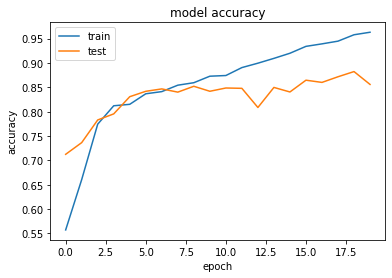

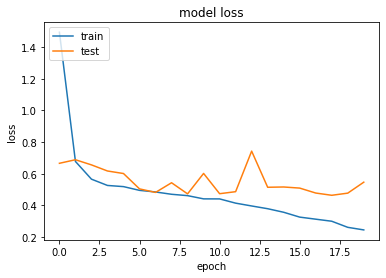

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5539567470550537 , AUC = 0.8497830033302307 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8568977718684995
test 0.8505455795171406

-----------------------------------------------------------------


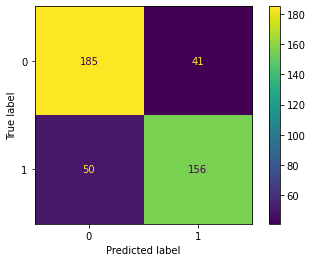

In [ ]:
# Create directory to save models
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
rt_sv_dir = '/content/models'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA_train[RUN]['MFCCS'][:]
  textra    = DATA_train[RUN]['EXTRA'][:]
  timgs     = DATA_train[RUN]['MEL'][:]
  labels    = DATA_train[RUN]['LABELS'][:]

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  val_features= DATA_val[RUN]['MFCCS'][:]
  val_extra   = DATA_val[RUN]['EXTRA'][:]
  val_imgs    = DATA_val[RUN]['MEL'][:]
  val_labels  = DATA_val[RUN]['LABELS'][ :]


  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=20,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.show()

0
Num_samples: 432
acc:  0.7893518518518519


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


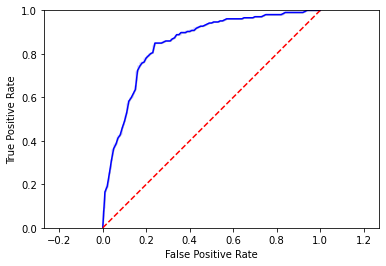

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/020--0.547--0.246.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

##50epoch with LR0.01

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6205957410306449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5011598934616376
77/77 - 17s - loss: 2.9552 - auc: 0.5317 - val_loss: 0.6672 - val_auc: 0.6175 - 17s/epoch - 224ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8228217280349982


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7546180943380015
77/77 - 15s - loss: 0.5832 - auc: 0.7470 - val_loss: 0.5382 - val_auc: 0.8229 - 15s/epoch - 197ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8234221869571745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7868373571612681
77/77 - 15s - loss: 0.5303 - auc: 0.8012 - val_loss: 0.5201 - val_auc: 0.8227 - 15s/epoch - 196ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7837704531320366


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.783550992353295
77/77 - 15s - loss: 0.5250 - auc: 0.8090 - val_loss: 0.6235 - val_auc: 0.7837 - 15s/epoch - 196ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8338444382492334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7834650743190996
77/77 - 15s - loss: 0.5099 - auc: 0.8233 - val_loss: 0.4944 - val_auc: 0.8332 - 15s/epoch - 196ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8422508631597005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7789328980152934
77/77 - 15s - loss: 0.5012 - auc: 0.8301 - val_loss: 0.5000 - val_auc: 0.8418 - 15s/epoch - 197ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8461967360768587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.779276570152075
77/77 - 15s - loss: 0.4930 - auc: 0.8379 - val_loss: 0.5027 - val_auc: 0.8463 - 15s/epoch - 200ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8413930646994487


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8079302345562334
77/77 - 15s - loss: 0.4877 - auc: 0.8394 - val_loss: 0.5067 - val_auc: 0.8417 - 15s/epoch - 197ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.855182174947996


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7890497465417992
77/77 - 15s - loss: 0.4876 - auc: 0.8398 - val_loss: 0.4936 - val_auc: 0.8550 - 15s/epoch - 197ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8385194398576056


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8065555460091074
77/77 - 15s - loss: 0.4855 - auc: 0.8372 - val_loss: 0.5075 - val_auc: 0.8384 - 15s/epoch - 198ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.861958782783985


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.794591459747401
77/77 - 15s - loss: 0.4868 - auc: 0.8398 - val_loss: 0.4796 - val_auc: 0.8621 - 15s/epoch - 197ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8383264352040487


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8157917346851105
77/77 - 15s - loss: 0.4879 - auc: 0.8398 - val_loss: 0.4972 - val_auc: 0.8385 - 15s/epoch - 197ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8298985653320753


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8068347796202423
77/77 - 15s - loss: 0.4668 - auc: 0.8550 - val_loss: 0.5132 - val_auc: 0.8300 - 15s/epoch - 198ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8615084385923527


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.824963484835467
77/77 - 15s - loss: 0.4646 - auc: 0.8595 - val_loss: 0.4920 - val_auc: 0.8616 - 15s/epoch - 198ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8227359481889729


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8176819314374087
77/77 - 15s - loss: 0.4555 - auc: 0.8656 - val_loss: 0.6609 - val_auc: 0.8230 - 15s/epoch - 197ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.821277690806545


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8124409313514906
77/77 - 15s - loss: 0.4528 - auc: 0.8666 - val_loss: 0.5601 - val_auc: 0.8213 - 15s/epoch - 197ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8240226458793507


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.820109115903428
77/77 - 15s - loss: 0.4451 - auc: 0.8697 - val_loss: 0.5464 - val_auc: 0.8235 - 15s/epoch - 196ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8544959361797947


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8254145545149927
77/77 - 15s - loss: 0.4462 - auc: 0.8719 - val_loss: 0.4849 - val_auc: 0.8545 - 15s/epoch - 197ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8585919238274968


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8104862960735459
77/77 - 15s - loss: 0.4483 - auc: 0.8696 - val_loss: 0.4681 - val_auc: 0.8582 - 15s/epoch - 196ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8487701314576142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8148036772918635
77/77 - 15s - loss: 0.4379 - auc: 0.8749 - val_loss: 0.4726 - val_auc: 0.8489 - 15s/epoch - 195ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8213741931333234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8048371853251997
77/77 - 15s - loss: 0.4182 - auc: 0.8883 - val_loss: 0.5943 - val_auc: 0.8214 - 15s/epoch - 198ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7900752718148871


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7720594552796631
77/77 - 15s - loss: 0.4196 - auc: 0.8854 - val_loss: 0.7236 - val_auc: 0.7889 - 15s/epoch - 198ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8206021745190968


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7779233611134978
77/77 - 15s - loss: 0.4107 - auc: 0.8932 - val_loss: 0.5237 - val_auc: 0.8203 - 15s/epoch - 199ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8506251206279085


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8225792593865453
77/77 - 15s - loss: 0.3982 - auc: 0.9006 - val_loss: 0.4920 - val_auc: 0.8509 - 15s/epoch - 198ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8544744912182882


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.82137640690781
77/77 - 15s - loss: 0.3870 - auc: 0.9047 - val_loss: 0.5011 - val_auc: 0.8537 - 15s/epoch - 197ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8576269005597135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8262737348569464
77/77 - 15s - loss: 0.3754 - auc: 0.9117 - val_loss: 0.4791 - val_auc: 0.8577 - 15s/epoch - 197ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8495850399948531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8311710628060829
77/77 - 15s - loss: 0.3628 - auc: 0.9169 - val_loss: 0.4814 - val_auc: 0.8498 - 15s/epoch - 197ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8469687546910853


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8323309562677206
77/77 - 15s - loss: 0.3474 - auc: 0.9248 - val_loss: 0.5448 - val_auc: 0.8461 - 15s/epoch - 197ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.868671055735455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.841599364206547
77/77 - 16s - loss: 0.3417 - auc: 0.9275 - val_loss: 0.4721 - val_auc: 0.8687 - 16s/epoch - 203ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8299629002165942


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8103144600051551
77/77 - 15s - loss: 0.3316 - auc: 0.9329 - val_loss: 0.5559 - val_auc: 0.8295 - 15s/epoch - 198ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8388411142801999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8237391528481828
77/77 - 15s - loss: 0.3336 - auc: 0.9310 - val_loss: 0.5367 - val_auc: 0.8380 - 15s/epoch - 197ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8649396324333597


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8371638456912106
77/77 - 15s - loss: 0.3141 - auc: 0.9405 - val_loss: 0.5107 - val_auc: 0.8636 - 15s/epoch - 198ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8610580944007206


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.835853595669731
77/77 - 15s - loss: 0.2829 - auc: 0.9508 - val_loss: 0.5353 - val_auc: 0.8599 - 15s/epoch - 199ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8381870429542579


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8337486038319443
77/77 - 15s - loss: 0.2803 - auc: 0.9513 - val_loss: 0.6291 - val_auc: 0.8346 - 15s/epoch - 198ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.814576140335828


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8022811238078873
77/77 - 15s - loss: 0.2628 - auc: 0.9568 - val_loss: 0.6350 - val_auc: 0.8138 - 15s/epoch - 198ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8622697347258261


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8388392473580205
77/77 - 15s - loss: 0.2616 - auc: 0.9572 - val_loss: 0.4951 - val_auc: 0.8615 - 15s/epoch - 198ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8478908880358559


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8133860297276397
77/77 - 15s - loss: 0.2254 - auc: 0.9692 - val_loss: 0.6028 - val_auc: 0.8463 - 15s/epoch - 198ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8595140571722675


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8259515422287138
77/77 - 15s - loss: 0.2164 - auc: 0.9711 - val_loss: 0.5537 - val_auc: 0.8566 - 15s/epoch - 196ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8502605562823013


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8285290832545752
77/77 - 15s - loss: 0.2172 - auc: 0.9706 - val_loss: 0.6273 - val_auc: 0.8484 - 15s/epoch - 197ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7987926486671956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7802216685282242
77/77 - 15s - loss: 0.2189 - auc: 0.9709 - val_loss: 0.7870 - val_auc: 0.7936 - 15s/epoch - 198ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8525658896442282


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8443594810550735
77/77 - 15s - loss: 0.2611 - auc: 0.9624 - val_loss: 0.5688 - val_auc: 0.8513 - 15s/epoch - 199ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.830027235101113


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8122153965117278
77/77 - 15s - loss: 0.2012 - auc: 0.9758 - val_loss: 0.8477 - val_auc: 0.8249 - 15s/epoch - 199ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8464540756149342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8248346077841741
77/77 - 15s - loss: 0.1970 - auc: 0.9762 - val_loss: 0.6522 - val_auc: 0.8419 - 15s/epoch - 198ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.834691514228732


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8108514477188762
77/77 - 15s - loss: 0.1701 - auc: 0.9822 - val_loss: 0.7704 - val_auc: 0.8309 - 15s/epoch - 198ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7939675323282794


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7374559670074748
77/77 - 15s - loss: 0.1643 - auc: 0.9832 - val_loss: 1.1308 - val_auc: 0.7828 - 15s/epoch - 197ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8392914584718321


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8206568433714237
77/77 - 15s - loss: 0.1460 - auc: 0.9869 - val_loss: 0.8704 - val_auc: 0.8340 - 15s/epoch - 197ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8514185842036414


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.845111263854283
77/77 - 15s - loss: 0.1541 - auc: 0.9852 - val_loss: 0.8248 - val_auc: 0.8469 - 15s/epoch - 196ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8484162895927603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8229229315233269
77/77 - 15s - loss: 0.1386 - auc: 0.9877 - val_loss: 0.7993 - val_auc: 0.8452 - 15s/epoch - 197ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.840524543758444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8236210155511643
77/77 - 15s - loss: 0.1338 - auc: 0.9887 - val_loss: 0.8884 - val_auc: 0.8348 - 15s/epoch - 197ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8483519547082412


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8331364378383022
77/77 - 15s - loss: 0.1374 - auc: 0.9879 - val_loss: 1.0522 - val_auc: 0.8414 - 15s/epoch - 197ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


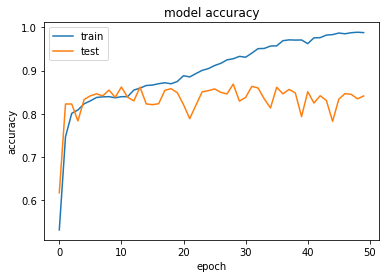

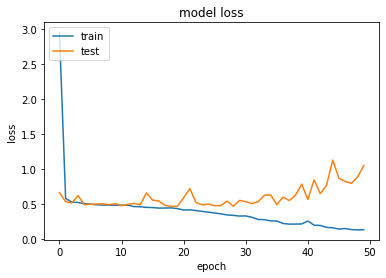

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.9798466563224792 , AUC = 0.8250923752784729 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8483519547082412
test 0.8331364378383022

-----------------------------------------------------------------


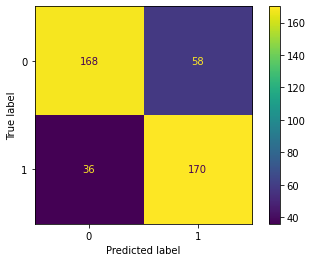

In [ ]:
# Create directory to save models
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
rt_sv_dir = '/content/models'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  optimizer = keras.optimizers.Adam(lr=0.01)
  MERGM.compile(
      optimizer = optimizer ,
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA_train[RUN]['MFCCS'][:]
  textra    = DATA_train[RUN]['EXTRA'][:]
  timgs     = DATA_train[RUN]['MEL'][:]
  labels    = DATA_train[RUN]['LABELS'][:]

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  val_features= DATA_val[RUN]['MFCCS'][:]
  val_extra   = DATA_val[RUN]['EXTRA'][:]
  val_imgs    = DATA_val[RUN]['MEL'][:]
  val_labels  = DATA_val[RUN]['LABELS'][ :]


  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=50,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.show()

0
Num_samples: 432
acc:  0.7824074074074074


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


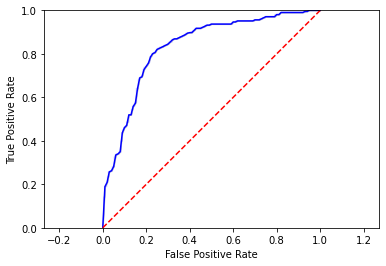

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/050--1.052--0.137.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

##use resnet50 

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(224,224),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(224,224)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(224,224)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch,X1_batch,X2_batch, X3_batch]
      return X_batch, Y_batch

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

#model = ResNet50(weights='imagenet', include_top=False)

In [ ]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=39)
  lay1   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = BatchNormalization()(lay1)
  lay3   = Dropout(0.5)(lay2)
  lay4   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay3)
  lay5   = BatchNormalization()(lay4)
  lay6   = Dropout(0.5)(lay5)

  #first +1 model
  inp11   = Input(shape=39)
  lay11   = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay21   = BatchNormalization()(lay1)
  lay31   = Dropout(0.5)(lay2)
  lay41   = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay3)
  lay51   = BatchNormalization()(lay4)
  lay61   = Dropout(0.5)(lay5)

  # first merge input models
  merge1 = concatenate([lay6,lay61])

# resnet
  inp2   = ResNet50(weights='imagenet', include_top=False)
  x = inp2.output

#first branch 
  x11 = GlobalAveragePooling2D()(x)
  x21   = BatchNormalization()(x11)
  x31   = Dropout(0.5)(x21)

#second branch
  x12 = GlobalAveragePooling2D()(x)
  x22   = BatchNormalization()(x12)
  x32   = Dropout(0.5)(x22)

#merge resnet 
  mergeXX = concatenate([x31,x32])
  x13   = BatchNormalization()(mergeXX)
  x23   = Dropout(0.5)(x13)


  # Second Model
#  inp2   = Input(shape=(64,64,3))
#  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
#  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
#  lay3_  = BatchNormalization()(lay2_)
#  lay4_  = Activation('relu')(lay3_)

 # lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
 # lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
 # lay7_  = BatchNormalization()(lay6_)
  #lay8_  = Activation('relu')(lay7_)

 # lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
 # lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  #lay11_ = BatchNormalization()(lay10_)
  #lay12_ = Activation('relu')(lay11_)

 # lay13_ = Flatten()(lay12_)
 # lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
 # lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=5,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = BatchNormalization()(lay31)
  lay33  = Dropout(0.5)(lay32)
  lay34  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay33)
  lay35  = BatchNormalization()(lay34)
  lay36  = Dropout(0.5)(lay35)

 # second merge input models
  merge2 = concatenate([merge1,lay36])

  # merge input models
  merge3 = concatenate([x23, merge2])

  # interpretation model
  hidden1 = Dense(256, activation='relu')(merge3)
  hidden2  = BatchNormalization()(hidden1)
  hidden3  = Dropout(0.5)(hidden2)
  output  = Dense(1, activation='sigmoid')(hidden3)
  MERGM   = Model(inputs=[inp1,inp11 ,inp2.input,inp3], outputs=output)
  
  for layer in inp2.layers:
    layer.trainable = False


  return MERGM

rm: cannot remove '/content/models/resnet': No such file or directory
94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6042117904398362


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5637297018644214
77/77 - 431s - loss: 0.8097 - auc: 0.7101 - val_loss: 0.7842 - val_auc: 0.6038 - 431s/epoch - 6s/step
Epoch 2/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7155540305805151


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5903428129564396
77/77 - 429s - loss: 0.6575 - auc: 0.7571 - val_loss: 0.6473 - val_auc: 0.7146 - 429s/epoch - 6s/step
Epoch 3/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.76170358774206


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6269438955236704
77/77 - 429s - loss: 0.5982 - auc: 0.7738 - val_loss: 0.5998 - val_auc: 0.7617 - 429s/epoch - 6s/step
Epoch 4/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7785378825245008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7070624624108601
77/77 - 435s - loss: 0.5712 - auc: 0.7859 - val_loss: 0.5877 - val_auc: 0.7786 - 435s/epoch - 6s/step
Epoch 5/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8198623233471296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7359094423919581
77/77 - 424s - loss: 0.5381 - auc: 0.8069 - val_loss: 0.5516 - val_auc: 0.8193 - 424s/epoch - 6s/step
Epoch 6/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8238296412257939


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7634246928430278
77/77 - 426s - loss: 0.5192 - auc: 0.8174 - val_loss: 0.5320 - val_auc: 0.8235 - 426s/epoch - 6s/step
Epoch 7/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8388625592417062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7789758570323913
77/77 - 433s - loss: 0.5121 - auc: 0.8232 - val_loss: 0.4992 - val_auc: 0.8390 - 433s/epoch - 6s/step
Epoch 8/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.855696854024147


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7902525990205345
77/77 - 432s - loss: 0.5144 - auc: 0.8263 - val_loss: 0.4879 - val_auc: 0.8554 - 432s/epoch - 6s/step
Epoch 9/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8509146276082434


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.796116504854369
77/77 - 414s - loss: 0.4969 - auc: 0.8335 - val_loss: 0.4808 - val_auc: 0.8510 - 414s/epoch - 5s/step
Epoch 10/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8577555703287513


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8096915542572385
77/77 - 423s - loss: 0.4944 - auc: 0.8354 - val_loss: 0.4699 - val_auc: 0.8578 - 423s/epoch - 5s/step
Epoch 11/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8549033904484141


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8067059025689493
77/77 - 427s - loss: 0.4799 - auc: 0.8457 - val_loss: 0.4664 - val_auc: 0.8551 - 427s/epoch - 6s/step
Epoch 12/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8670626836224828


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8136008248131282
77/77 - 418s - loss: 0.4709 - auc: 0.8555 - val_loss: 0.4510 - val_auc: 0.8672 - 418s/epoch - 5s/step
Epoch 13/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8629452510132745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8237606323567317
77/77 - 435s - loss: 0.4740 - auc: 0.8498 - val_loss: 0.4599 - val_auc: 0.8630 - 435s/epoch - 6s/step
Epoch 14/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8728957131521949


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8155125010739754
77/77 - 422s - loss: 0.4746 - auc: 0.8498 - val_loss: 0.4534 - val_auc: 0.8730 - 422s/epoch - 5s/step
Epoch 15/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8711801162316914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8139659764584586
77/77 - 427s - loss: 0.4602 - auc: 0.8595 - val_loss: 0.4423 - val_auc: 0.8712 - 427s/epoch - 6s/step
Epoch 16/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8647251828182969


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8223000257754103
77/77 - 414s - loss: 0.4552 - auc: 0.8624 - val_loss: 0.4616 - val_auc: 0.8647 - 414s/epoch - 5s/step
Epoch 17/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8760910124166327


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8152547469713893
77/77 - 422s - loss: 0.4666 - auc: 0.8555 - val_loss: 0.4426 - val_auc: 0.8759 - 422s/epoch - 5s/step
Epoch 18/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8751045441873431


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8127201649626256
77/77 - 434s - loss: 0.4598 - auc: 0.8599 - val_loss: 0.4405 - val_auc: 0.8751 - 434s/epoch - 6s/step
Epoch 19/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8727241534601445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8156843371423662
77/77 - 429s - loss: 0.4493 - auc: 0.8678 - val_loss: 0.4354 - val_auc: 0.8727 - 429s/epoch - 6s/step
Epoch 20/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8739036263429906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8139444969499098
77/77 - 424s - loss: 0.4544 - auc: 0.8644 - val_loss: 0.4446 - val_auc: 0.8739 - 424s/epoch - 6s/step
Epoch 21/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8637601595505136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.815276226479938
77/77 - 417s - loss: 0.4397 - auc: 0.8731 - val_loss: 0.4496 - val_auc: 0.8638 - 417s/epoch - 5s/step
Epoch 22/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8735390619973837


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8135793453045794
77/77 - 430s - loss: 0.4474 - auc: 0.8668 - val_loss: 0.4627 - val_auc: 0.8736 - 430s/epoch - 6s/step
Epoch 23/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8735176170358775


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8055460091073117
77/77 - 415s - loss: 0.4448 - auc: 0.8708 - val_loss: 0.4513 - val_auc: 0.8735 - 415s/epoch - 5s/step
Epoch 24/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8779996139906929


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8067703410945959
77/77 - 416s - loss: 0.4473 - auc: 0.8692 - val_loss: 0.4426 - val_auc: 0.8780 - 416s/epoch - 5s/step
Epoch 25/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8795865411421587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8182618781682276
77/77 - 432s - loss: 0.4431 - auc: 0.8724 - val_loss: 0.4287 - val_auc: 0.8797 - 432s/epoch - 6s/step
Epoch 26/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8727241534601445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8068347796202422
77/77 - 427s - loss: 0.4290 - auc: 0.8785 - val_loss: 0.4485 - val_auc: 0.8726 - 427s/epoch - 6s/step
Epoch 27/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8753189938024062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8122261362660022
77/77 - 411s - loss: 0.4330 - auc: 0.8777 - val_loss: 0.4427 - val_auc: 0.8755 - 411s/epoch - 5s/step
Epoch 28/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8822671613304454


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8264455709253372
77/77 - 418s - loss: 0.4299 - auc: 0.8789 - val_loss: 0.4394 - val_auc: 0.8823 - 418s/epoch - 5s/step
Epoch 29/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8712873410392228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.82137640690781
77/77 - 416s - loss: 0.4355 - auc: 0.8760 - val_loss: 0.4406 - val_auc: 0.8716 - 416s/epoch - 5s/step
Epoch 30/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.876262572108683


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8191210585101814
77/77 - 426s - loss: 0.4420 - auc: 0.8713 - val_loss: 0.4474 - val_auc: 0.8762 - 426s/epoch - 6s/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


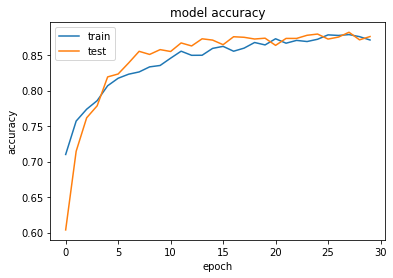

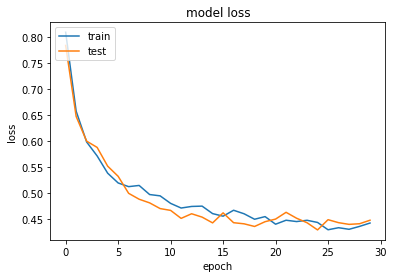

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5519694089889526 , AUC = 0.8195828199386597 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.876262572108683
test 0.8191210585101814

-----------------------------------------------------------------


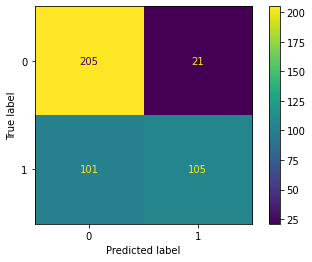

In [ ]:
# Create directory to save models
import matplotlib.pyplot as plt

rt_sv_dir = '/content/models/resnet'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  #optimizer = keras.optimizers.Adam(lr=0.01)

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])
  

  tfeatures = DATA_train[RUN]['MFCCS'][:]
  textra    = DATA_train[RUN]['EXTRA'][:]
  timgs     = DATA_train[RUN]['MEL'][:]
  labels    = DATA_train[RUN]['LABELS'][:]

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  val_features= DATA_val[RUN]['MFCCS'][:]
  val_extra   = DATA_val[RUN]['EXTRA'][:]
  val_imgs    = DATA_val[RUN]['MEL'][:]
  val_labels  = DATA_val[RUN]['LABELS'][ :]


#  tfeatures = DATA_train[RUN]['MFCCS'][:]
#  textra    = DATA_train[RUN]['EXTRA'][:]
#  timgs     = DATA_train[RUN]['MEL'][:]
#  labels    = DATA_train[RUN]['LABELS'][:]
#
#  test_features= DATA_test[RUN]['MFCCS'][ : ]
#  test_extra   = DATA_test[RUN]['EXTRA'][ : ]
#  test_imgs    = DATA_test[RUN]['MEL'][ : ]
#  test_labels  = DATA_test[RUN]['LABELS'][ : ]
#                                        
#  val_features= DATA_val[RUN]['MFCCS'][  :]
#  val_extra   = DATA_val[RUN]['EXTRA'][:]
#  val_imgs    = DATA_val[RUN]['MEL'][  :]
#  val_labels  = DATA_val[RUN]['LABELS'][  :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(224,224))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(224,224))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(224,224))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=30,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig('accuracy.png')

  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig('loss.png')

  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/030--0.459--0.483.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(224,224))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()